In [126]:
import sys
import numpy as np
import os
import cv2
import logging
from image_utils import standardize
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
from unet_meli import UNet,weights_init
# from unet_val import UNet
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from shapeSorter import SimpleSegmentationDataset
from IOU_computations import *
from random import randint
import time

In [127]:
%matplotlib notebook

In [128]:
!gpustat

coeus  Sun Apr 15 17:49:47 2018
[0] TITAN X (Pascal) | 25'C,   0 % |  5522 / 12189 MB | s161362(3171M) s161362(2341M)
[1] TITAN X (Pascal) | 51'C,   3 % | 11623 / 12189 MB | rapal(11613M)
[2] TITAN X (Pascal) | 54'C,   3 % | 11623 / 12189 MB | rapal(11613M)
[3] TITAN X (Pascal) | 35'C,   0 % |     0 / 12189 MB |
[4] TITAN X (Pascal) | 55'C,  33 % | 11623 / 12189 MB | rapal(11613M)
[5] TITAN X (Pascal) | 37'C,   0 % |     0 / 12189 MB |
[6] TITAN X (Pascal) | 36'C,   0 % |     0 / 12189 MB |
[7] TITAN X (Pascal) | 56'C,  34 % | 11623 / 12189 MB | rapal(11613M)


In [129]:
##########
GLOBAL_PATH='MODEL_SHAPE_PYTORCH_MELI/'
##########

if not os.path.exists(GLOBAL_PATH):
            os.makedirs(GLOBAL_PATH)
        
#############
PATH_TRAINING='TRAINING/'
PATH_VALIDATION='VALIDATION/'
PATH_TEST='TEST/'

PATH_INPUT='INPUT/'
PATH_OUTPUT='OUTPUT/'
##############

        
INPUT_CHANNELS=3
NB_CLASSES=3

SIZE_PATCH=120
##############
MODEL_PATH_SAVE=GLOBAL_PATH+'pytorch_shape_meli'
MODEL_PATH_RESTORE=''
TEST_SAVE=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

##############

REC_SAVE=200#2000
DROPOUT=0.1#0.9
DEFAULT_BATCH_SIZE = 32#8
DEFAULT_EPOCHS = 18#300
DEFAULT_VALID=10#100
DISPLAY_STEP=10#100

###############
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_FILTERS_SIZE=3
DEFAULT_LR=0.01#0.0001

####### TMP folder for IOU

TMP_IOU=TEST_SAVE+'TMP_IOU/'
if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)

In [130]:
 class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param lr: learning rate
    """
    def __init__(self, net, batch_size=10, lr=0.0001,nb_classes=4):
        self.net = net
        self.batch_size = batch_size
        self.lr = lr
        self.nb_classes=nb_classes
    def _initialize(self, prediction_path):
        
        self.optimizer = optim.Adam(self.net.parameters(),lr=self.lr)
        self.prediction_path = prediction_path
        
    
    
    def train(self, save_path='', restore_path='',  epochs=3, dropout=0.9, display_step=1, validation_batch_size=30,rec_save=1, prediction_path = '',data_aug=None):
        """
        Lauches the training process
        

        :param save_path: path where to store checkpoints
        :param restore_path: path where is the model to restore is stored
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param prediction_path: path where to save predictions on each epoch
        """
        ###Visualize Training  loss and lr
        fig,axs =plt.subplots(1, 2,figsize=(6,3))
        draw_update([],[],fig,axs)
        
        
        
        ###Tune Learning rate
        reduce_lr_steps = [1,5, 10, 100,200]
        
        if epochs == 0:
            return save_path
        if save_path=='':
            return 'Specify a path where to store the Model'
        
        self._initialize(prediction_path)
            
        ###Validation loader
          
        
        val_generator=SimpleSegmentationDataset(SIZE_PATCH, 3, alpha =1.0,virtual_size=30)
        val_loader = DataLoader(val_generator, batch_size=validation_batch_size,shuffle=True, num_workers=1)
        
        RBD=randint(0,int(val_loader.__len__())-1)
        self.store_init(val_loader,"_init",RBD)
        
        ###Training loader
        train_generator=SimpleSegmentationDataset(SIZE_PATCH, 3, alpha =1.0,virtual_size=4960)#4960
        train_loader = DataLoader(train_generator, batch_size=self.batch_size,shuffle=True, num_workers=1)
        lr_train=np.zeros(train_loader.__len__()*epochs)
        
        
        if restore_path=='':
            loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif=save_metrics(epochs,train_loader.__len__(),TEST_SAVE,'w')
            
            print('Model trained from scratch')
        else:
            loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif=save_metrics(epochs,train_loader.__len__(),TEST_SAVE,'a')
            self.net.load_state_dict(torch.load(restore_path))
            print('Model loaded from {}'.format(restore_path))

        logging.info("Start optimization")

        counter=0
        
        for epoch in range(epochs):
            ##tune learning reate
            if epoch in reduce_lr_steps:
                self.lr = self.lr * 0.3
                self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
            
            total_loss = 0
            error_tot=0
            train_loader = DataLoader(train_generator, batch_size=self.batch_size,shuffle=True, num_workers=1)
            for i_batch,sample in enumerate(train_loader):
                
                ##Real Batch
                batch_x=standardize(sample['input'])
                batch_y=sample['groundtruth']
        
                ##Variables input and output transformed for cuda
                X = Variable(batch_x.float())
                X=X.permute(0,3,1,2).cuda()  
                Y = Variable(batch_y.float())
                Y=Y.cuda() 
                
                ## Fwd+loss+bckwrd
                probs=predict(self.net,X,self.optimizer)
                self.optimizer.zero_grad()
                loss=criterion(Y,probs)
                loss.backward()
                self.optimizer.step()
                
                ## Store tracking training (loss+lr)
                total_loss+=loss.data[0]
                loss_train[counter]=loss.data[0]
                lr_train[counter]=self.lr
                file_train.write(str(loss_train[counter])+'\n')
                counter+=1
                
                if i_batch % display_step == 0:
                    self.output_training_stats(i_batch,X,Y)
                    draw_update(loss_train,lr_train,fig,axs)
                    
                if counter % rec_save == 0:
                    torch.save(self.net.state_dict(),save_path + 'CP{}.pth'.format(counter))
                    print('Checkpoint {} saved !'.format(counter))

            logging.info(" Training {:}, Minibatch Loss= {:.4f}".format("epoch_%s"%epoch,total_loss/train_loader.__len__() ))
            error_rate_v,loss_v,iou_v,iou_acc_v,f1_v=self.store_validation(val_loader, "epoch_%s"%epoch,RBD,save_patches=False)
            IOU_verif[epoch]=iou_v
            IOU_acc_verif[epoch]=iou_acc_v
            f1_IOU_verif[epoch]=f1_v
            loss_verif[epoch]=loss_v
            
            IOU_file_verif.write(str(IOU_verif[epoch])+'\n')
            IOU_acc_file_verif.write(str(IOU_acc_verif[epoch])+'\n')
            f1_IOU_file_verif.write(str(f1_IOU_verif[epoch])+'\n')
            file_verif.write(str(loss_verif[epoch])+'\n')
            
        error_rate_v,loss_v,iou_v,iou_acc_v,f1_v=self.store_validation(val_loader, "epoch_%s"%epoch,RBD,save_patches=True)
        time.sleep(4)
        plt.close(fig)
        return save_path, loss_train,loss_verif,IOU_verif,IOU_acc_verif,f1_IOU_verif      
    
    def output_training_stats(self, step, batch_x, batch_y):
        # Calculate batch loss and accuracy

        predictions=predict(self.net,batch_x,self.optimizer)
        loss=criterion(batch_y,predictions)
        loss=loss.data[0]
        predictions=predictions.data.cpu().numpy()
        groundtruth=batch_y.data.cpu().numpy()
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Minibatch error= {:.1f}%".format(step,loss,error_rate(predictions, groundtruth)))
        
        
        
        
    def store_init(self,val_loader,name,random_batch_display,*,save_patches=True):
        loss_v=0
        error_rate_v=0

        for i_batch,sample in enumerate(val_loader):
            batch_x=standardize(sample['input'])
            batch_y=sample['groundtruth']

            
            X = Variable(batch_x.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(batch_y.float())
            Y=Y.cuda()  
    
            
            probs=predict(self.net,X,self.optimizer)
            loss=criterion(Y,probs)
            
            loss_v+=loss.data[0]
            prediction_v=probs.data.cpu().numpy()
            groundtruth=np.asarray(batch_y)
            
            error_rate_v+=error_rate(prediction_v,groundtruth)
            if i_batch==random_batch_display:    
                batch_x=np.asarray(batch_x)
                plot_summary(prediction_v,groundtruth,batch_x,name,self.prediction_path,save_patches)

    
                         
        loss_v/=val_loader.__len__()   
        error_rate_v/=val_loader.__len__()  
        logging.info("Verification  loss= {:.4f},error= {:.1f}%".format(loss_v,error_rate_v))
        
    
    def store_validation(self,val_loader, name,random_batch_display,*,save_patches=True):
        loss_v=0
        iou_v=0
        iou_acc_v=0
        f1_v=0
        error_rate_v=0

        for i_batch,sample in enumerate(val_loader):
            
            batch_x=standardize(sample['input'])
            batch_y=sample['groundtruth']
    
            X = Variable(batch_x.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(batch_y.float())
            Y=Y.cuda()  
            
            probs=predict(self.net,X,self.optimizer)
            loss=criterion(Y,probs)
            loss_v+=loss.data[0]
            
            prediction_v=probs.data.cpu().numpy()
            groundtruth=np.asarray(batch_y)
            iou_acc,f1,iou=predict_score_batch(TMP_IOU,np.argmax(groundtruth,3),np.argmax(prediction_v,3))
            
            iou_acc_v+=iou_acc
            iou_v+=iou
            f1_v+=f1
            error_rate_v+=error_rate(prediction_v,groundtruth)
            
            if i_batch==random_batch_display:   
                batch_x=np.asarray(batch_x)
                plot_summary(prediction_v,groundtruth,batch_x,name,self.prediction_path,save_patches)
            

        loss_v/=val_loader.__len__()   
        iou_v/=val_loader.__len__()  
        iou_acc_v/=val_loader.__len__()  
        f1_v/=val_loader.__len__()  
        error_rate_v/=val_loader.__len__()  

        logging.info("Verification  loss= {:.4f},error rate= {:.1f}%, IOU = {:.4f}, IOU Precision = {:.4f}%, F1 IOU= {:.4f}%".format(loss_v,error_rate_v,iou_v,iou_acc_v,f1_v))


        return error_rate_v,loss_v,iou_v,iou_acc_v,f1_v

In [131]:
loss_fn=nn.CrossEntropyLoss()

def criterion(y,y_):
    
    y = y.contiguous().view(-1,y.size()[-1])
    y_ = y_.contiguous().view(-1,y.size()[-1])
    y = y.max(-1)[1]
    loss = loss_fn( y_,y)
    
    return loss
    
def predict(net,batch_x,optimizer): 
    
#     optimizer.zero_grad()
    logits=net(batch_x) 
#     logits=net.forward(batch_x) 
    probs=logits.permute(0,2,3,1)
    return probs

    
#     loss=Fu.binary_cross_entropy_with_logits(logits,Y)
#     probs = Fu.softmax(logits,dim=1)
        
    


def save_metrics(epochs,training_len,prediction_path,mode):
    #STORE loss for ANALYSIS
    loss_train=np.zeros(epochs*training_len)
    file_train = open(prediction_path+'loss_train.txt',mode) 
    loss_verif=np.zeros(epochs)
    file_verif = open(prediction_path+'loss_verif.txt',mode) 
    #STORE IOU for ANALYSIS
    IOU_verif=np.zeros(epochs)
    IOU_file_verif = open(prediction_path+'iou_verif.txt',mode)
    #STORE IOU_ACC for ANALYSIS
    IOU_acc_verif=np.zeros(epochs)
    IOU_acc_file_verif = open(prediction_path+'iou_acc_verif.txt',mode)
    #STORE f1_IOU for ANALYSIS
    f1_IOU_verif=np.zeros(epochs)
    f1_IOU_file_verif = open(prediction_path+'f1_iou_verif.txt',mode) 
    
    return loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif
def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))
def plot_summary(predictions,labels,pansharp,epoch,prediction_path,save_patches):

    
    fig,axs=plt.subplots(3, len(pansharp),figsize=(3*len(pansharp),9))
    #figsize=(8*len(pansharp),24)
   
    labels=np.argmax(labels, 3) 
    logits=np.argmax(predictions, 3)

    

    for i in range(len(pansharp)):
        cax1=axs[0,i].imshow(pansharp[i])
#         fig.colorbar(cax1,ax=axs[0,i])
        cax2=axs[1,i].imshow(labels[i])
#         fig.colorbar(cax2,ax=axs[1,i])
        cax3=axs[2,i].imshow(logits[i])
#         fig.colorbar(cax3,ax=axs[2,i])

        
        if save_patches:

            plt.imsave(prediction_path+epoch+'_Panchro_'+str(i)+'.jpg',pansharp[i]/(np.amax(pansharp[i])))
            plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels[i])
            plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',logits[i])

    fig.canvas.draw()
    time.sleep(4)
    plt.close(fig)

def draw_update(loss,lr,fig,axs):
    
    if len(loss)==0 and len(lr)==0:

        axs[0].set_ylim(0,0.001)
        axs[0].set_title('Loss train')
        axs[1].set_ylim(0,1)
        axs[0].set_title('Learning rate')
    else:
        global_step=len(loss)
        ite=np.arange(global_step)
        axs[0].clear()
        axs[1].clear()
        line1, = axs[0].plot(ite, loss, 'r-') 
        line2, = axs[1].plot(ite, lr, 'b-') 
        fig.canvas.draw()
        time.sleep(4)

<IPython.core.display.Javascript object>


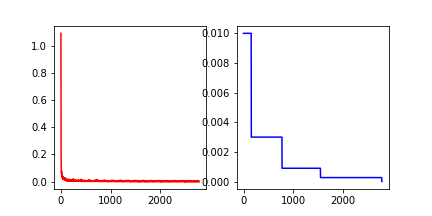

<IPython.core.display.Javascript object>


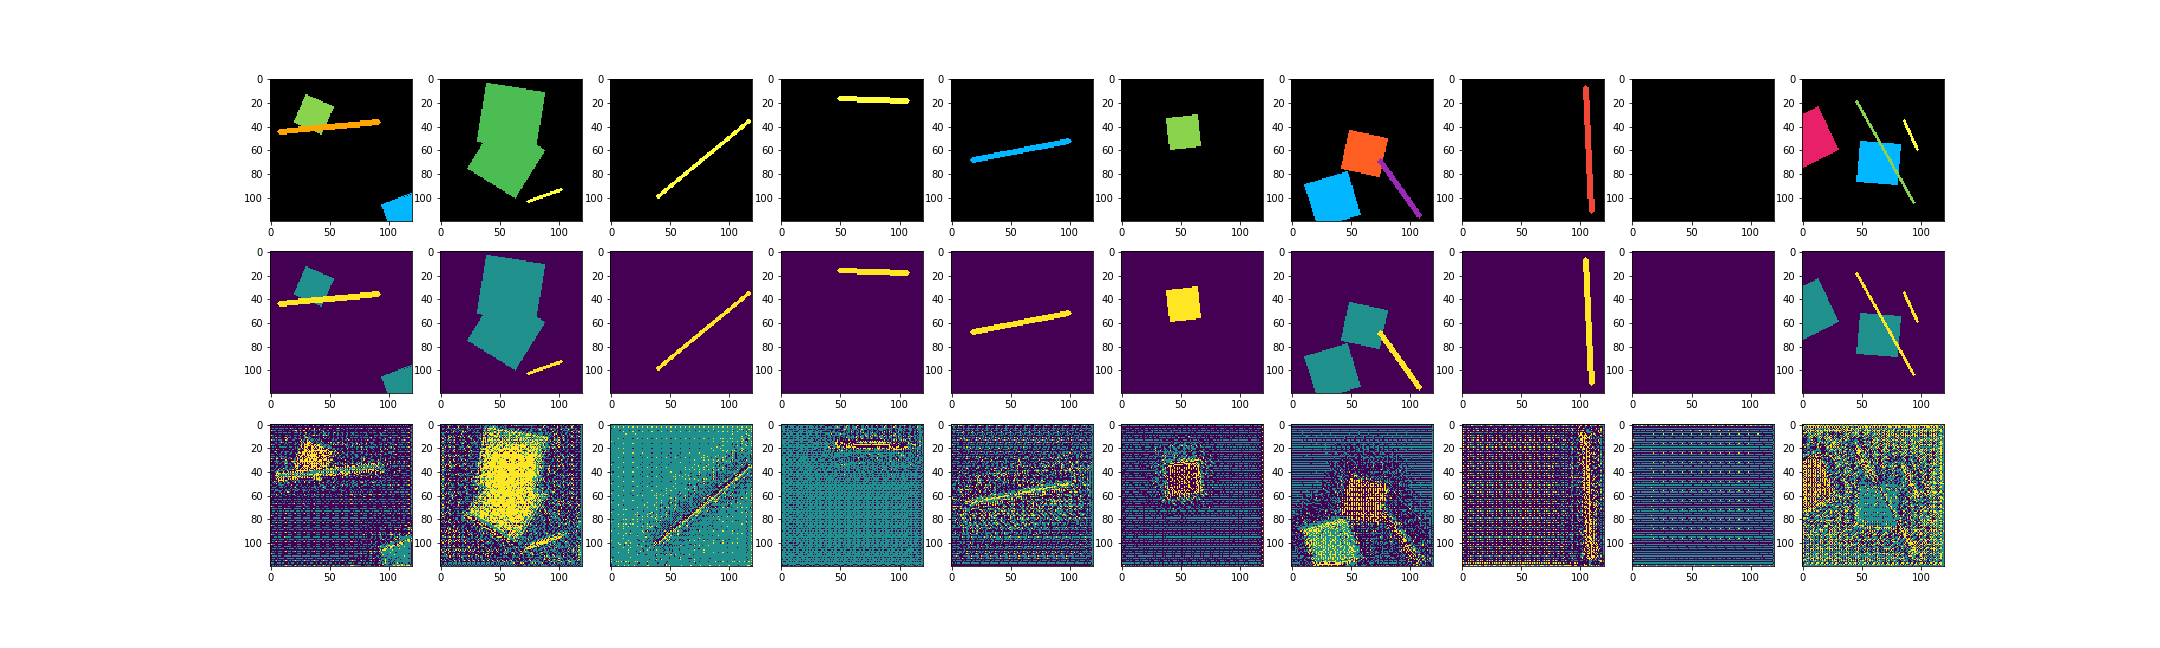

2018-04-15 17:50:05,081 Verification  loss= 1.0934,error= 50.0%
2018-04-15 17:50:05,188 Start optimization


Model trained from scratch


2018-04-15 17:50:05,623 Iter 0, Minibatch Loss= 0.5293, Minibatch error= 6.6%
2018-04-15 17:50:11,639 Iter 10, Minibatch Loss= 0.0861, Minibatch error= 3.0%
2018-04-15 17:50:17,577 Iter 20, Minibatch Loss= 0.0445, Minibatch error= 1.8%
2018-04-15 17:50:23,557 Iter 30, Minibatch Loss= 0.0373, Minibatch error= 1.2%
2018-04-15 17:50:29,509 Iter 40, Minibatch Loss= 0.0198, Minibatch error= 0.5%
2018-04-15 17:50:35,472 Iter 50, Minibatch Loss= 0.0300, Minibatch error= 0.8%
2018-04-15 17:50:41,407 Iter 60, Minibatch Loss= 0.0224, Minibatch error= 0.5%
2018-04-15 17:50:47,342 Iter 70, Minibatch Loss= 0.0191, Minibatch error= 0.6%
2018-04-15 17:50:53,298 Iter 80, Minibatch Loss= 0.0095, Minibatch error= 0.2%
2018-04-15 17:50:59,253 Iter 90, Minibatch Loss= 0.0076, Minibatch error= 0.2%
2018-04-15 17:51:05,177 Iter 100, Minibatch Loss= 0.0107, Minibatch error= 0.2%
2018-04-15 17:51:11,012 Iter 110, Minibatch Loss= 0.0141, Minibatch error= 0.4%
2018-04-15 17:51:16,957 Iter 120, Minibatch Loss= 0

<IPython.core.display.Javascript object>


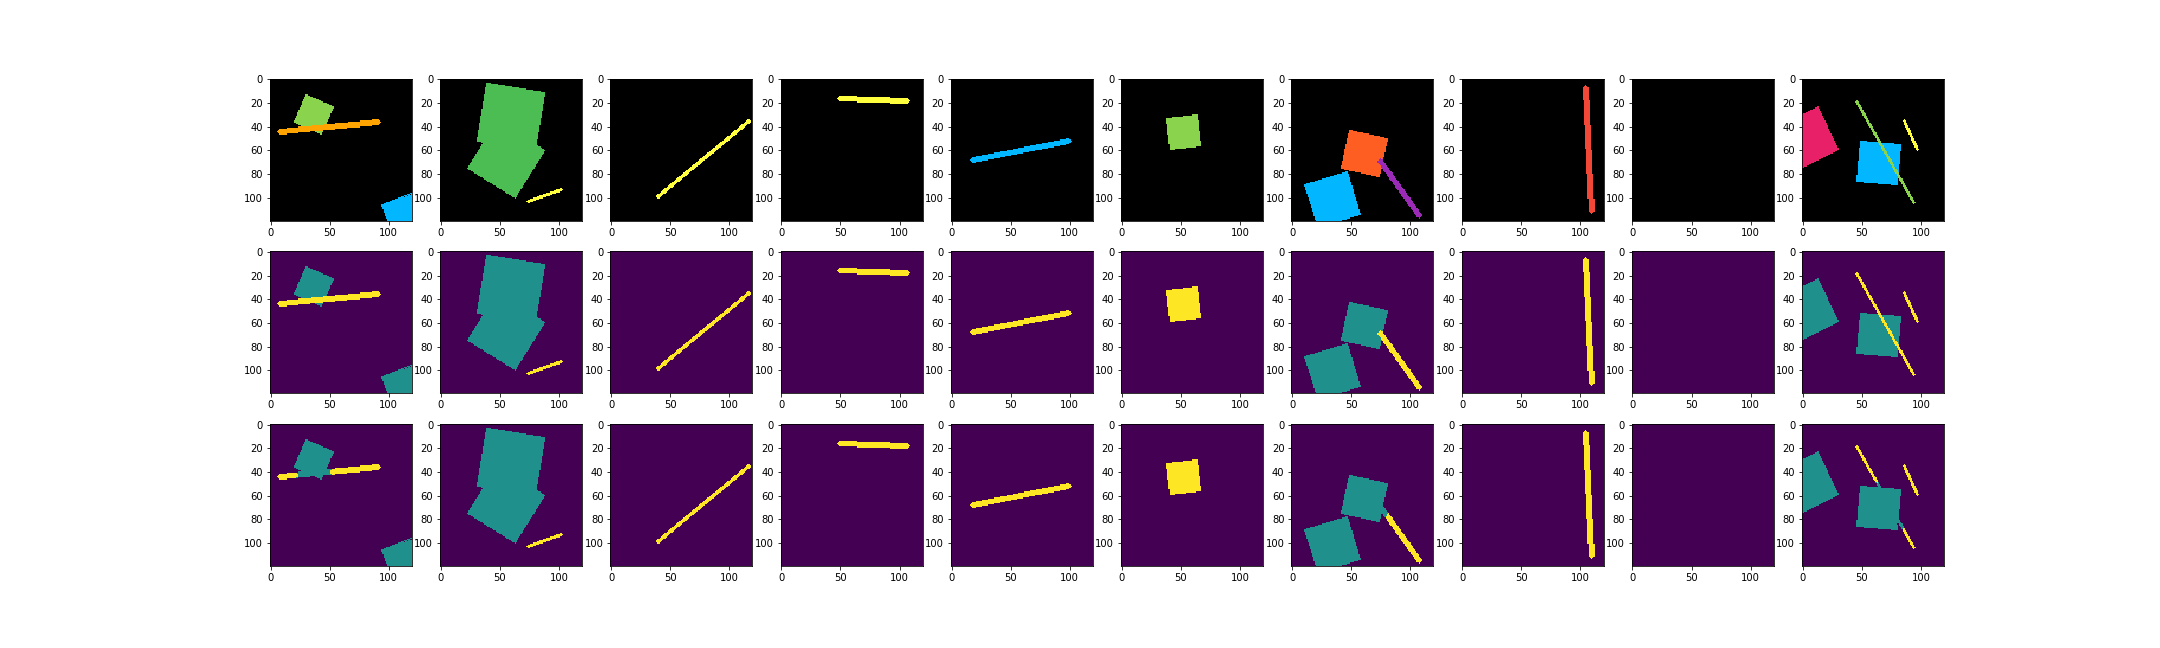

2018-04-15 17:51:50,417 Verification  loss= 0.0125,error rate= 0.3%, IOU = 0.8861, IOU Precision = 90.7500%, F1 IOU= 87.5444%
2018-04-15 17:51:50,850 Iter 0, Minibatch Loss= 0.0137, Minibatch error= 0.3%
2018-04-15 17:51:56,847 Iter 10, Minibatch Loss= 0.0111, Minibatch error= 0.3%
2018-04-15 17:52:02,820 Iter 20, Minibatch Loss= 0.0070, Minibatch error= 0.2%
2018-04-15 17:52:08,766 Iter 30, Minibatch Loss= 0.0065, Minibatch error= 0.2%
2018-04-15 17:52:14,688 Iter 40, Minibatch Loss= 0.0044, Minibatch error= 0.1%


Checkpoint 200 saved !


2018-04-15 17:52:20,838 Iter 50, Minibatch Loss= 0.0060, Minibatch error= 0.2%
2018-04-15 17:52:26,800 Iter 60, Minibatch Loss= 0.0068, Minibatch error= 0.2%
2018-04-15 17:52:32,743 Iter 70, Minibatch Loss= 0.0085, Minibatch error= 0.2%
2018-04-15 17:52:38,744 Iter 80, Minibatch Loss= 0.0032, Minibatch error= 0.1%
2018-04-15 17:52:44,707 Iter 90, Minibatch Loss= 0.0022, Minibatch error= 0.1%
2018-04-15 17:52:50,634 Iter 100, Minibatch Loss= 0.0045, Minibatch error= 0.1%
2018-04-15 17:52:56,595 Iter 110, Minibatch Loss= 0.0055, Minibatch error= 0.2%
2018-04-15 17:53:02,519 Iter 120, Minibatch Loss= 0.0044, Minibatch error= 0.2%
2018-04-15 17:53:08,454 Iter 130, Minibatch Loss= 0.0057, Minibatch error= 0.2%
2018-04-15 17:53:14,389 Iter 140, Minibatch Loss= 0.0056, Minibatch error= 0.2%
2018-04-15 17:53:20,255 Iter 150, Minibatch Loss= 0.0064, Minibatch error= 0.2%
2018-04-15 17:53:25,068  Training epoch_1, Minibatch Loss= 0.0065


<IPython.core.display.Javascript object>


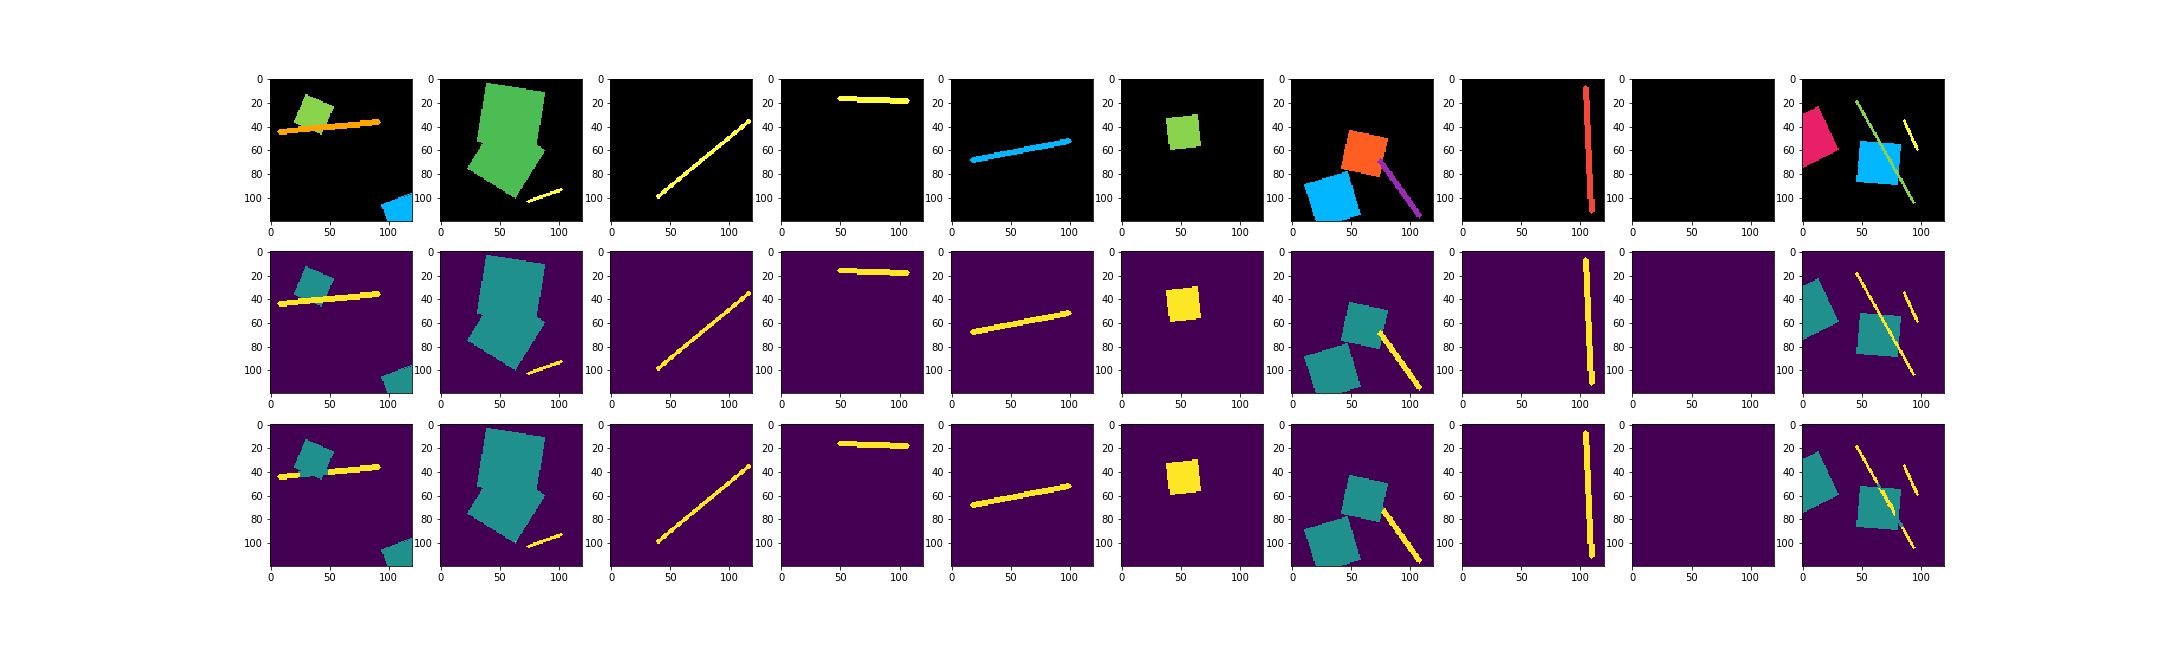

2018-04-15 17:53:36,125 Verification  loss= 0.0094,error rate= 0.3%, IOU = 0.9161, IOU Precision = 94.2778%, F1 IOU= 89.3759%
2018-04-15 17:53:36,574 Iter 0, Minibatch Loss= 0.0070, Minibatch error= 0.2%
2018-04-15 17:53:42,584 Iter 10, Minibatch Loss= 0.0064, Minibatch error= 0.2%
2018-04-15 17:53:48,562 Iter 20, Minibatch Loss= 0.0041, Minibatch error= 0.1%
2018-04-15 17:53:54,517 Iter 30, Minibatch Loss= 0.0041, Minibatch error= 0.2%
2018-04-15 17:54:00,455 Iter 40, Minibatch Loss= 0.0023, Minibatch error= 0.1%
2018-04-15 17:54:06,406 Iter 50, Minibatch Loss= 0.0047, Minibatch error= 0.1%
2018-04-15 17:54:12,419 Iter 60, Minibatch Loss= 0.0054, Minibatch error= 0.2%
2018-04-15 17:54:18,515 Iter 70, Minibatch Loss= 0.0062, Minibatch error= 0.2%
2018-04-15 17:54:24,437 Iter 80, Minibatch Loss= 0.0025, Minibatch error= 0.1%


Checkpoint 400 saved !


2018-04-15 17:54:30,570 Iter 90, Minibatch Loss= 0.0014, Minibatch error= 0.1%
2018-04-15 17:54:36,511 Iter 100, Minibatch Loss= 0.0036, Minibatch error= 0.1%
2018-04-15 17:54:42,486 Iter 110, Minibatch Loss= 0.0058, Minibatch error= 0.2%
2018-04-15 17:54:48,441 Iter 120, Minibatch Loss= 0.0040, Minibatch error= 0.1%
2018-04-15 17:54:54,378 Iter 130, Minibatch Loss= 0.0039, Minibatch error= 0.2%
2018-04-15 17:55:00,321 Iter 140, Minibatch Loss= 0.0050, Minibatch error= 0.2%
2018-04-15 17:55:06,283 Iter 150, Minibatch Loss= 0.0055, Minibatch error= 0.2%
2018-04-15 17:55:11,093  Training epoch_2, Minibatch Loss= 0.0049


<IPython.core.display.Javascript object>


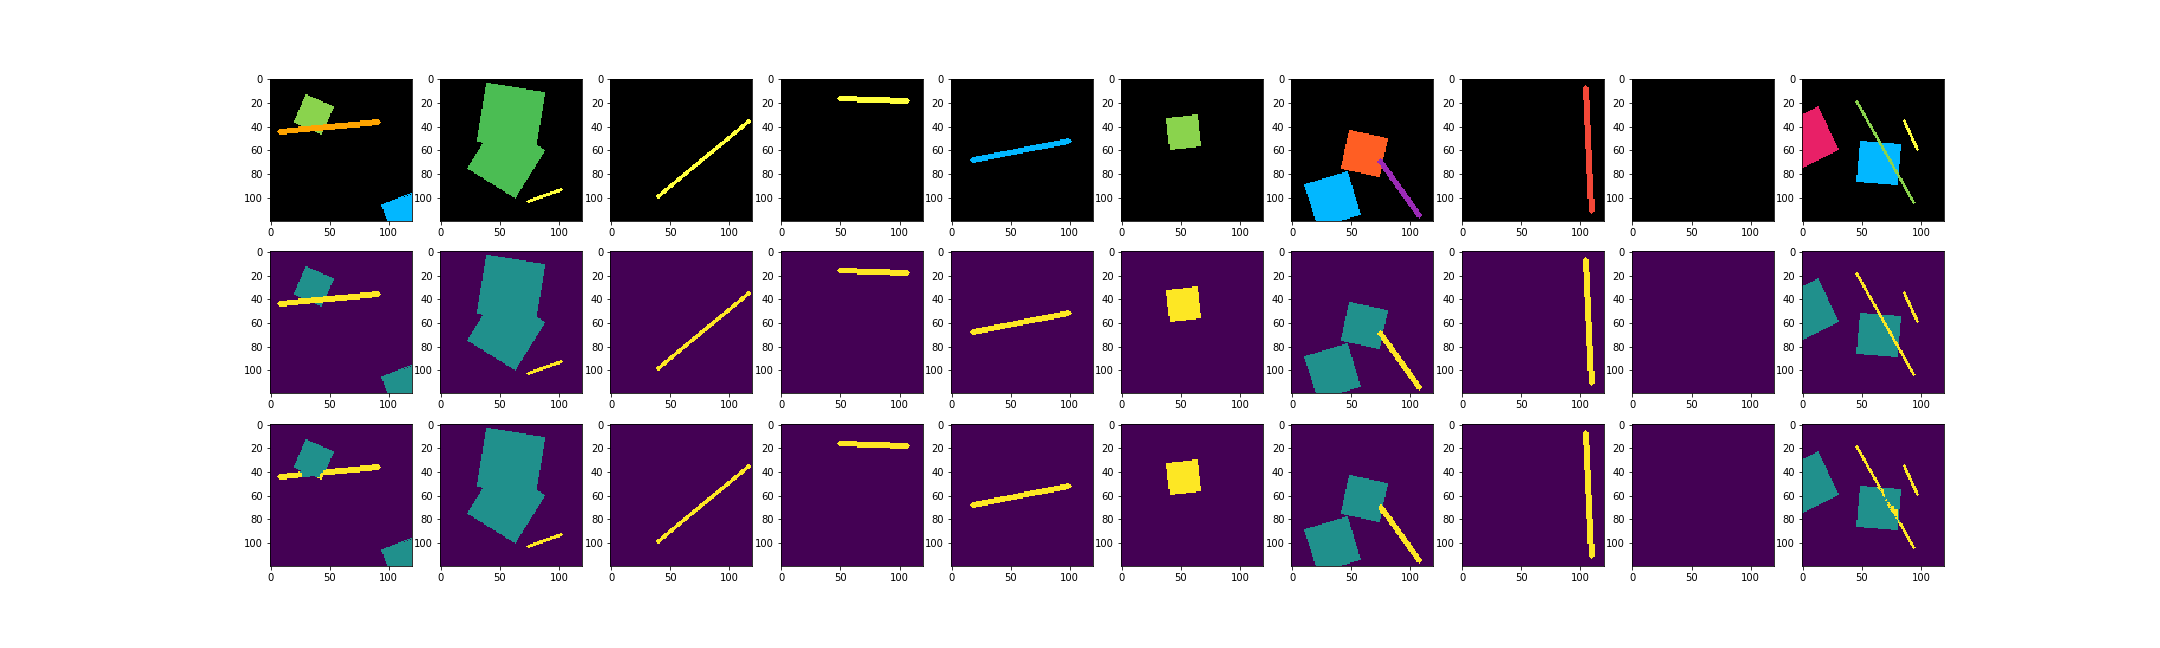

2018-04-15 17:55:22,381 Verification  loss= 0.0061,error rate= 0.2%, IOU = 0.9241, IOU Precision = 94.0278%, F1 IOU= 88.8697%
2018-04-15 17:55:22,811 Iter 0, Minibatch Loss= 0.0053, Minibatch error= 0.2%
2018-04-15 17:55:28,818 Iter 10, Minibatch Loss= 0.0056, Minibatch error= 0.2%
2018-04-15 17:55:34,770 Iter 20, Minibatch Loss= 0.0029, Minibatch error= 0.1%
2018-04-15 17:55:40,731 Iter 30, Minibatch Loss= 0.0031, Minibatch error= 0.1%
2018-04-15 17:55:46,672 Iter 40, Minibatch Loss= 0.0020, Minibatch error= 0.1%
2018-04-15 17:55:52,637 Iter 50, Minibatch Loss= 0.0055, Minibatch error= 0.2%
2018-04-15 17:55:58,616 Iter 60, Minibatch Loss= 0.0045, Minibatch error= 0.2%
2018-04-15 17:56:04,650 Iter 70, Minibatch Loss= 0.0048, Minibatch error= 0.2%
2018-04-15 17:56:10,661 Iter 80, Minibatch Loss= 0.0022, Minibatch error= 0.1%
2018-04-15 17:56:16,622 Iter 90, Minibatch Loss= 0.0012, Minibatch error= 0.0%
2018-04-15 17:56:22,444 Iter 100, Minibatch Loss= 0.0029, Minibatch error= 0.1%
2018-

Checkpoint 600 saved !


2018-04-15 17:56:46,402 Iter 140, Minibatch Loss= 0.0043, Minibatch error= 0.2%
2018-04-15 17:56:52,345 Iter 150, Minibatch Loss= 0.0041, Minibatch error= 0.1%
2018-04-15 17:56:57,176  Training epoch_3, Minibatch Loss= 0.0039


<IPython.core.display.Javascript object>


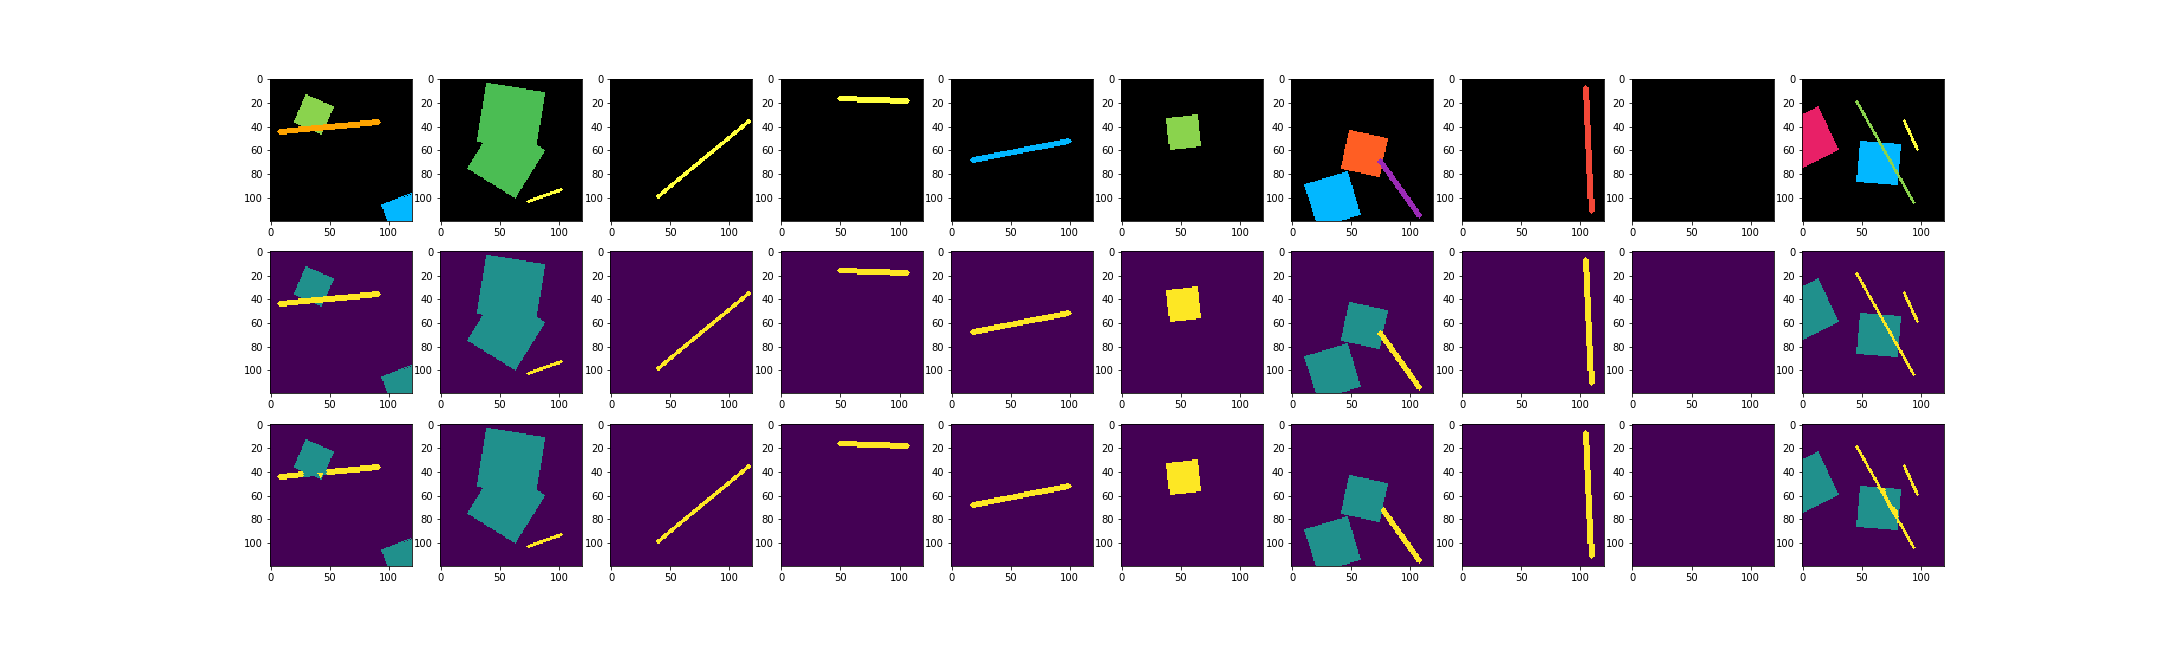

2018-04-15 17:57:07,662 Verification  loss= 0.0058,error rate= 0.2%, IOU = 0.9387, IOU Precision = 95.8056%, F1 IOU= 92.0803%
2018-04-15 17:57:08,062 Iter 0, Minibatch Loss= 0.0066, Minibatch error= 0.2%
2018-04-15 17:57:14,047 Iter 10, Minibatch Loss= 0.0050, Minibatch error= 0.2%
2018-04-15 17:57:20,025 Iter 20, Minibatch Loss= 0.0026, Minibatch error= 0.1%
2018-04-15 17:57:25,979 Iter 30, Minibatch Loss= 0.0026, Minibatch error= 0.1%
2018-04-15 17:57:32,100 Iter 40, Minibatch Loss= 0.0018, Minibatch error= 0.0%
2018-04-15 17:57:38,061 Iter 50, Minibatch Loss= 0.0045, Minibatch error= 0.1%
2018-04-15 17:57:44,019 Iter 60, Minibatch Loss= 0.0042, Minibatch error= 0.1%
2018-04-15 17:57:50,028 Iter 70, Minibatch Loss= 0.0041, Minibatch error= 0.1%
2018-04-15 17:57:56,048 Iter 80, Minibatch Loss= 0.0025, Minibatch error= 0.1%
2018-04-15 17:58:02,031 Iter 90, Minibatch Loss= 0.0019, Minibatch error= 0.1%
2018-04-15 17:58:08,042 Iter 100, Minibatch Loss= 0.0030, Minibatch error= 0.1%
2018-

<IPython.core.display.Javascript object>


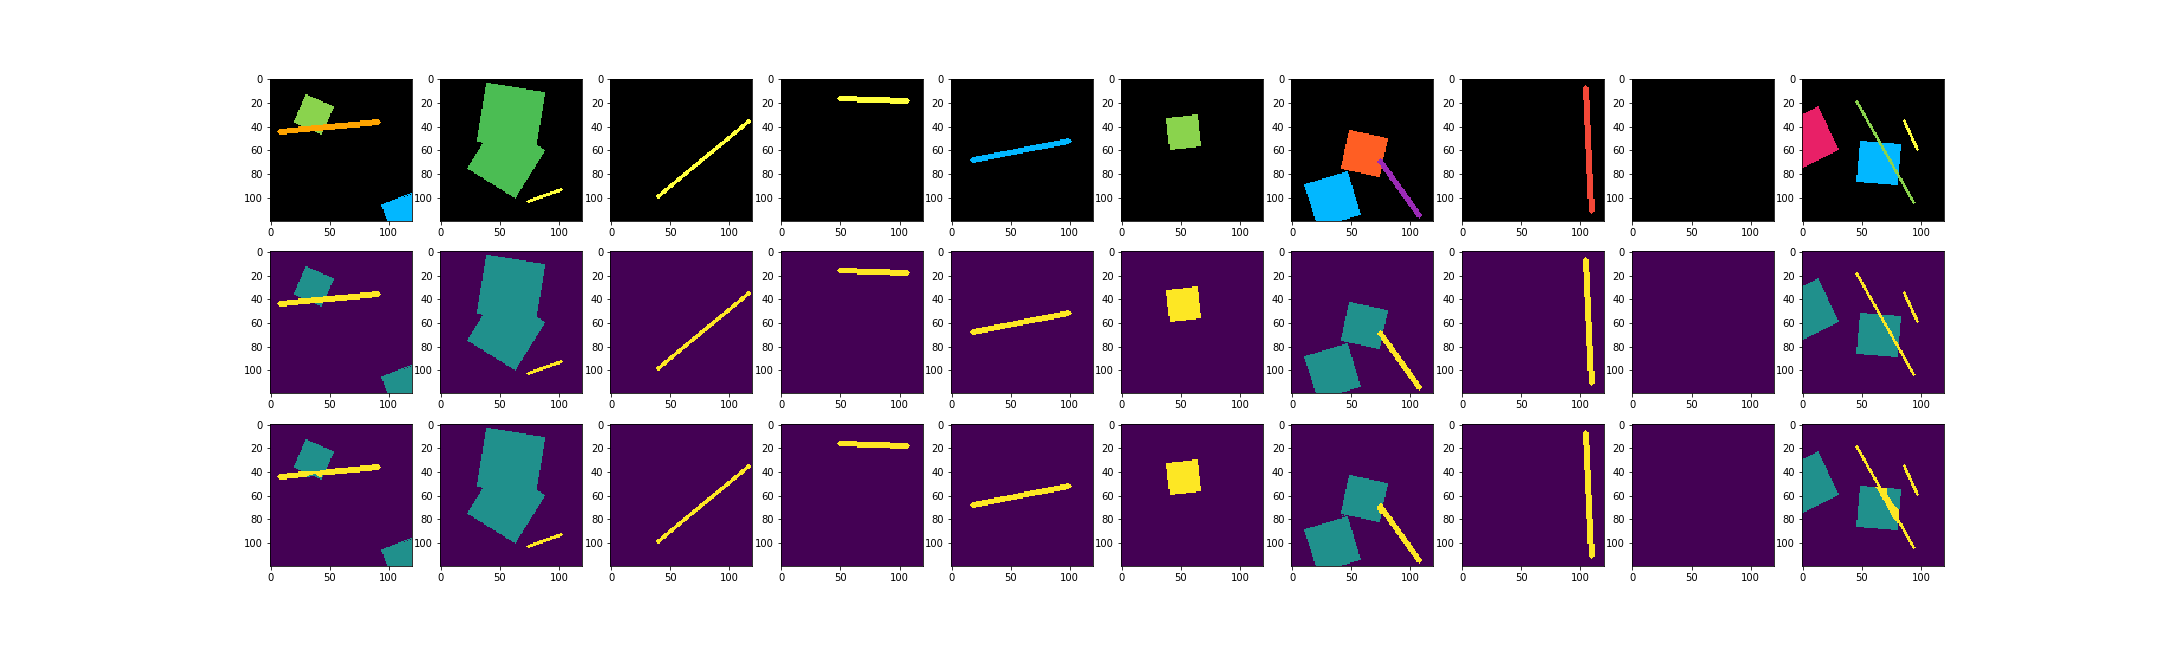

2018-04-15 17:58:54,040 Verification  loss= 0.0058,error rate= 0.2%, IOU = 0.9429, IOU Precision = 96.4722%, F1 IOU= 88.0564%
2018-04-15 17:58:54,481 Iter 0, Minibatch Loss= 0.0054, Minibatch error= 0.2%
2018-04-15 17:59:00,482 Iter 10, Minibatch Loss= 0.0038, Minibatch error= 0.1%
2018-04-15 17:59:06,476 Iter 20, Minibatch Loss= 0.0019, Minibatch error= 0.1%


Checkpoint 800 saved !


2018-04-15 17:59:12,610 Iter 30, Minibatch Loss= 0.0023, Minibatch error= 0.1%
2018-04-15 17:59:18,571 Iter 40, Minibatch Loss= 0.0015, Minibatch error= 0.1%
2018-04-15 17:59:24,557 Iter 50, Minibatch Loss= 0.0048, Minibatch error= 0.1%
2018-04-15 17:59:30,507 Iter 60, Minibatch Loss= 0.0040, Minibatch error= 0.2%
2018-04-15 17:59:36,446 Iter 70, Minibatch Loss= 0.0032, Minibatch error= 0.1%
2018-04-15 17:59:42,405 Iter 80, Minibatch Loss= 0.0012, Minibatch error= 0.0%
2018-04-15 17:59:48,403 Iter 90, Minibatch Loss= 0.0008, Minibatch error= 0.0%
2018-04-15 17:59:54,375 Iter 100, Minibatch Loss= 0.0023, Minibatch error= 0.1%
2018-04-15 18:00:00,338 Iter 110, Minibatch Loss= 0.0047, Minibatch error= 0.1%
2018-04-15 18:00:06,311 Iter 120, Minibatch Loss= 0.0024, Minibatch error= 0.1%
2018-04-15 18:00:12,305 Iter 130, Minibatch Loss= 0.0026, Minibatch error= 0.1%
2018-04-15 18:00:18,275 Iter 140, Minibatch Loss= 0.0034, Minibatch error= 0.1%
2018-04-15 18:00:24,216 Iter 150, Minibatch Los

<IPython.core.display.Javascript object>


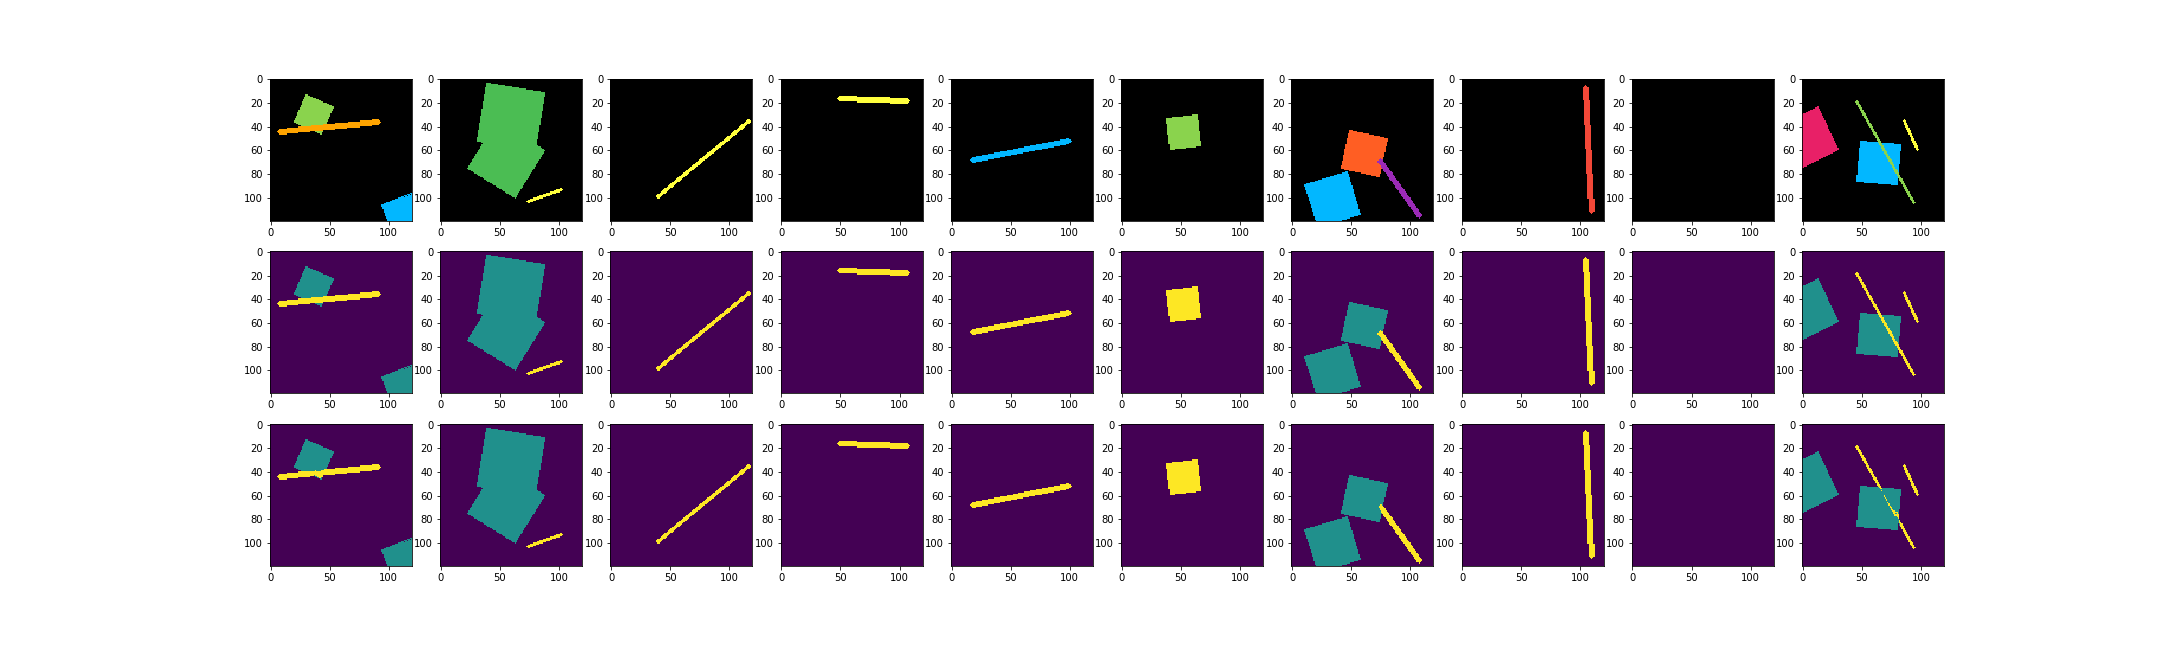

2018-04-15 18:00:40,862 Verification  loss= 0.0038,error rate= 0.1%, IOU = 0.9369, IOU Precision = 94.6944%, F1 IOU= 91.3313%
2018-04-15 18:00:41,274 Iter 0, Minibatch Loss= 0.0039, Minibatch error= 0.1%
2018-04-15 18:00:47,396 Iter 10, Minibatch Loss= 0.0031, Minibatch error= 0.1%
2018-04-15 18:00:53,352 Iter 20, Minibatch Loss= 0.0016, Minibatch error= 0.1%
2018-04-15 18:00:59,360 Iter 30, Minibatch Loss= 0.0020, Minibatch error= 0.1%
2018-04-15 18:01:05,347 Iter 40, Minibatch Loss= 0.0017, Minibatch error= 0.1%
2018-04-15 18:01:11,298 Iter 50, Minibatch Loss= 0.0035, Minibatch error= 0.1%
2018-04-15 18:01:17,152 Iter 60, Minibatch Loss= 0.0032, Minibatch error= 0.1%


Checkpoint 1000 saved !


2018-04-15 18:01:23,242 Iter 70, Minibatch Loss= 0.0031, Minibatch error= 0.1%
2018-04-15 18:01:29,213 Iter 80, Minibatch Loss= 0.0009, Minibatch error= 0.0%
2018-04-15 18:01:35,194 Iter 90, Minibatch Loss= 0.0007, Minibatch error= 0.0%
2018-04-15 18:01:41,194 Iter 100, Minibatch Loss= 0.0019, Minibatch error= 0.0%
2018-04-15 18:01:47,147 Iter 110, Minibatch Loss= 0.0037, Minibatch error= 0.1%
2018-04-15 18:01:53,097 Iter 120, Minibatch Loss= 0.0023, Minibatch error= 0.1%
2018-04-15 18:01:59,082 Iter 130, Minibatch Loss= 0.0025, Minibatch error= 0.1%
2018-04-15 18:02:05,096 Iter 140, Minibatch Loss= 0.0032, Minibatch error= 0.1%
2018-04-15 18:02:11,066 Iter 150, Minibatch Loss= 0.0024, Minibatch error= 0.1%
2018-04-15 18:02:15,886  Training epoch_6, Minibatch Loss= 0.0026


<IPython.core.display.Javascript object>


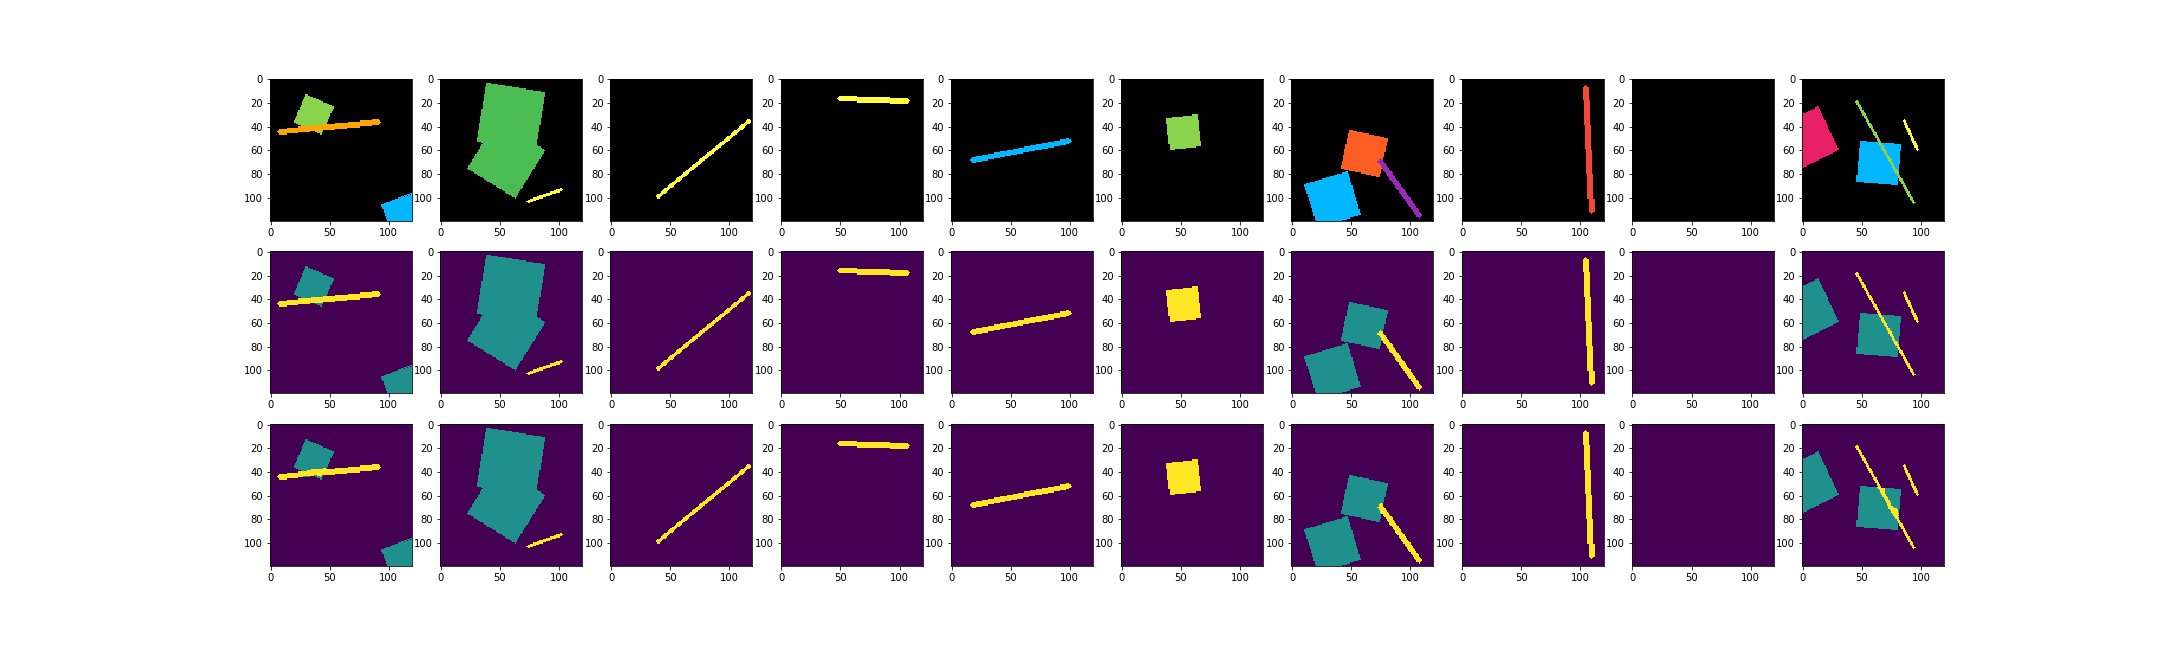

2018-04-15 18:02:27,064 Verification  loss= 0.0039,error rate= 0.2%, IOU = 0.9473, IOU Precision = 96.2222%, F1 IOU= 92.7385%
2018-04-15 18:02:27,487 Iter 0, Minibatch Loss= 0.0029, Minibatch error= 0.1%
2018-04-15 18:02:33,433 Iter 10, Minibatch Loss= 0.0037, Minibatch error= 0.1%
2018-04-15 18:02:39,375 Iter 20, Minibatch Loss= 0.0016, Minibatch error= 0.1%
2018-04-15 18:02:45,276 Iter 30, Minibatch Loss= 0.0019, Minibatch error= 0.1%
2018-04-15 18:02:51,237 Iter 40, Minibatch Loss= 0.0014, Minibatch error= 0.1%
2018-04-15 18:02:57,198 Iter 50, Minibatch Loss= 0.0052, Minibatch error= 0.1%
2018-04-15 18:03:03,133 Iter 60, Minibatch Loss= 0.0037, Minibatch error= 0.1%
2018-04-15 18:03:09,091 Iter 70, Minibatch Loss= 0.0027, Minibatch error= 0.1%
2018-04-15 18:03:15,063 Iter 80, Minibatch Loss= 0.0008, Minibatch error= 0.0%
2018-04-15 18:03:21,004 Iter 90, Minibatch Loss= 0.0016, Minibatch error= 0.0%
2018-04-15 18:03:26,936 Iter 100, Minibatch Loss= 0.0019, Minibatch error= 0.0%
2018-

Checkpoint 1200 saved !


2018-04-15 18:03:39,130 Iter 120, Minibatch Loss= 0.0026, Minibatch error= 0.1%
2018-04-15 18:03:45,061 Iter 130, Minibatch Loss= 0.0021, Minibatch error= 0.1%
2018-04-15 18:03:51,025 Iter 140, Minibatch Loss= 0.0027, Minibatch error= 0.1%
2018-04-15 18:03:56,949 Iter 150, Minibatch Loss= 0.0020, Minibatch error= 0.1%
2018-04-15 18:04:01,919  Training epoch_7, Minibatch Loss= 0.0024


<IPython.core.display.Javascript object>


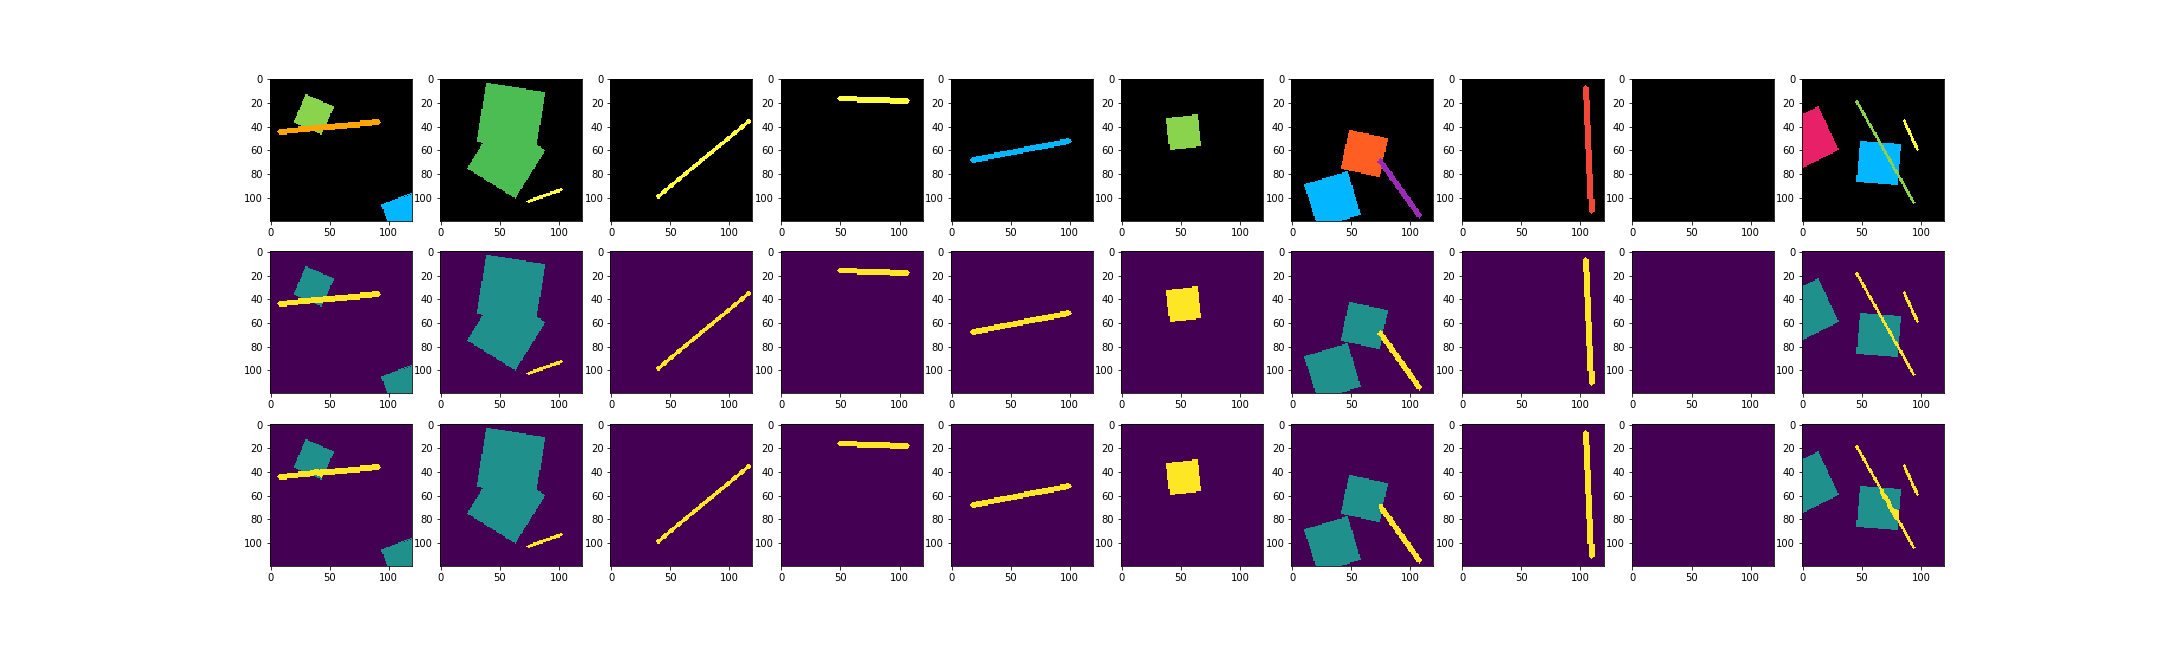

2018-04-15 18:04:13,918 Verification  loss= 0.0033,error rate= 0.1%, IOU = 0.9523, IOU Precision = 96.3333%, F1 IOU= 91.9245%
2018-04-15 18:04:14,351 Iter 0, Minibatch Loss= 0.0037, Minibatch error= 0.1%
2018-04-15 18:04:20,345 Iter 10, Minibatch Loss= 0.0031, Minibatch error= 0.1%
2018-04-15 18:04:26,356 Iter 20, Minibatch Loss= 0.0011, Minibatch error= 0.0%
2018-04-15 18:04:32,307 Iter 30, Minibatch Loss= 0.0020, Minibatch error= 0.1%
2018-04-15 18:04:38,264 Iter 40, Minibatch Loss= 0.0011, Minibatch error= 0.0%
2018-04-15 18:04:44,260 Iter 50, Minibatch Loss= 0.0039, Minibatch error= 0.1%
2018-04-15 18:04:50,235 Iter 60, Minibatch Loss= 0.0030, Minibatch error= 0.1%
2018-04-15 18:04:56,191 Iter 70, Minibatch Loss= 0.0024, Minibatch error= 0.1%
2018-04-15 18:05:02,148 Iter 80, Minibatch Loss= 0.0008, Minibatch error= 0.0%
2018-04-15 18:05:08,137 Iter 90, Minibatch Loss= 0.0009, Minibatch error= 0.0%
2018-04-15 18:05:14,120 Iter 100, Minibatch Loss= 0.0019, Minibatch error= 0.0%
2018-

<IPython.core.display.Javascript object>


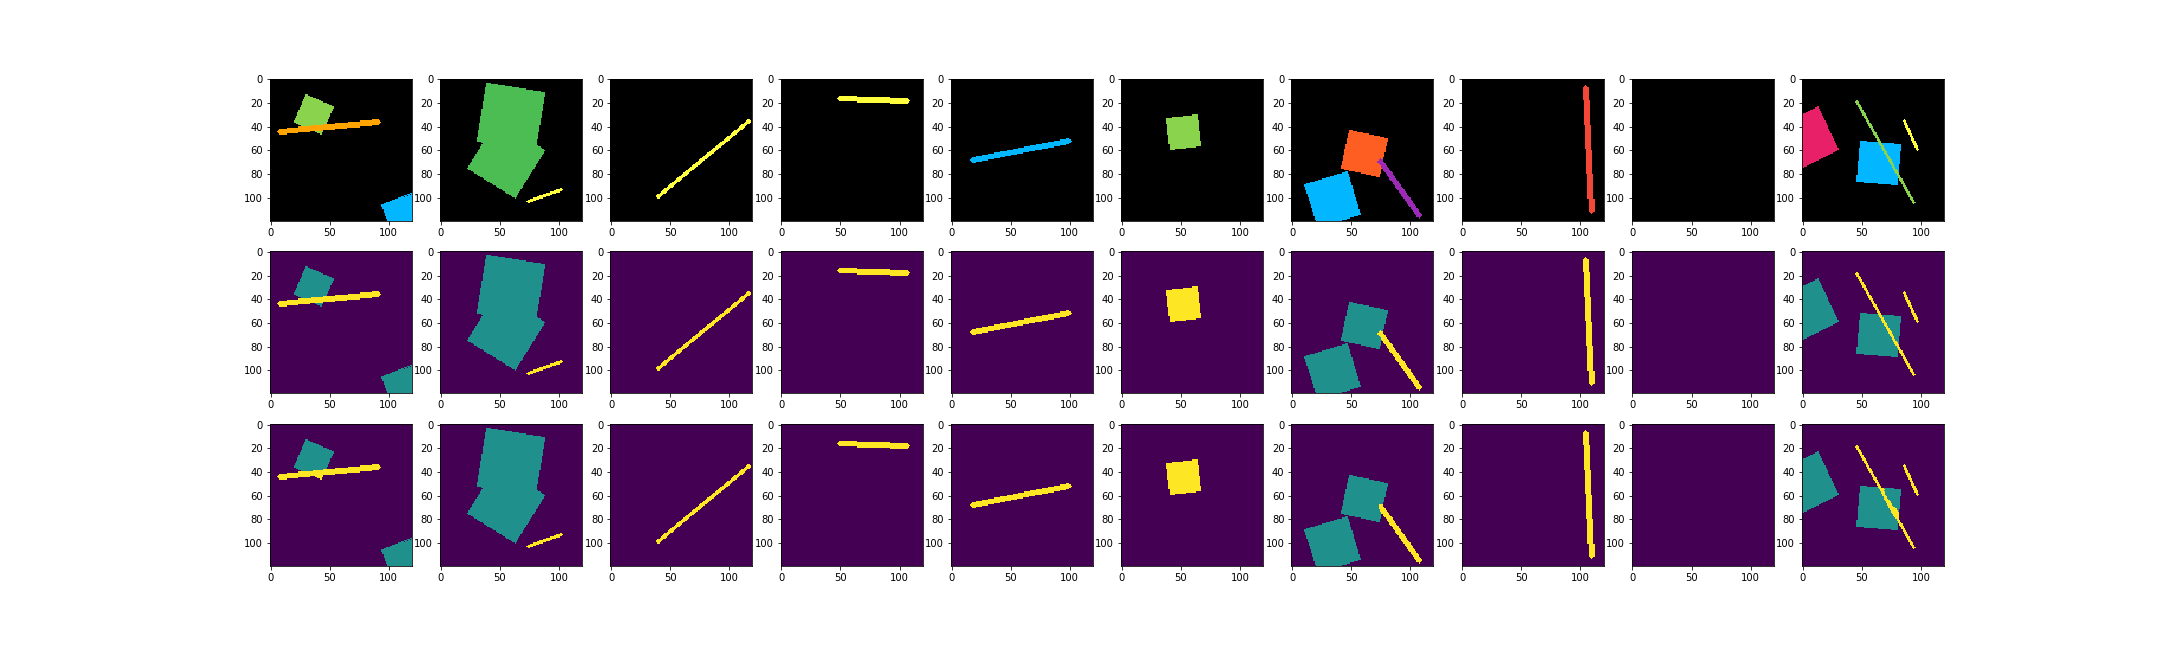

2018-04-15 18:06:00,680 Verification  loss= 0.0037,error rate= 0.1%, IOU = 0.9550, IOU Precision = 96.4722%, F1 IOU= 93.9721%
2018-04-15 18:06:01,113 Iter 0, Minibatch Loss= 0.0029, Minibatch error= 0.1%


Checkpoint 1400 saved !


2018-04-15 18:06:07,224 Iter 10, Minibatch Loss= 0.0030, Minibatch error= 0.1%
2018-04-15 18:06:13,187 Iter 20, Minibatch Loss= 0.0011, Minibatch error= 0.0%
2018-04-15 18:06:19,159 Iter 30, Minibatch Loss= 0.0019, Minibatch error= 0.1%
2018-04-15 18:06:25,141 Iter 40, Minibatch Loss= 0.0008, Minibatch error= 0.0%
2018-04-15 18:06:31,116 Iter 50, Minibatch Loss= 0.0039, Minibatch error= 0.1%
2018-04-15 18:06:37,062 Iter 60, Minibatch Loss= 0.0027, Minibatch error= 0.1%
2018-04-15 18:06:43,025 Iter 70, Minibatch Loss= 0.0025, Minibatch error= 0.1%
2018-04-15 18:06:49,005 Iter 80, Minibatch Loss= 0.0010, Minibatch error= 0.0%
2018-04-15 18:06:54,958 Iter 90, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:07:00,914 Iter 100, Minibatch Loss= 0.0018, Minibatch error= 0.0%
2018-04-15 18:07:06,885 Iter 110, Minibatch Loss= 0.0035, Minibatch error= 0.1%
2018-04-15 18:07:12,880 Iter 120, Minibatch Loss= 0.0021, Minibatch error= 0.1%
2018-04-15 18:07:18,845 Iter 130, Minibatch Loss=

<IPython.core.display.Javascript object>


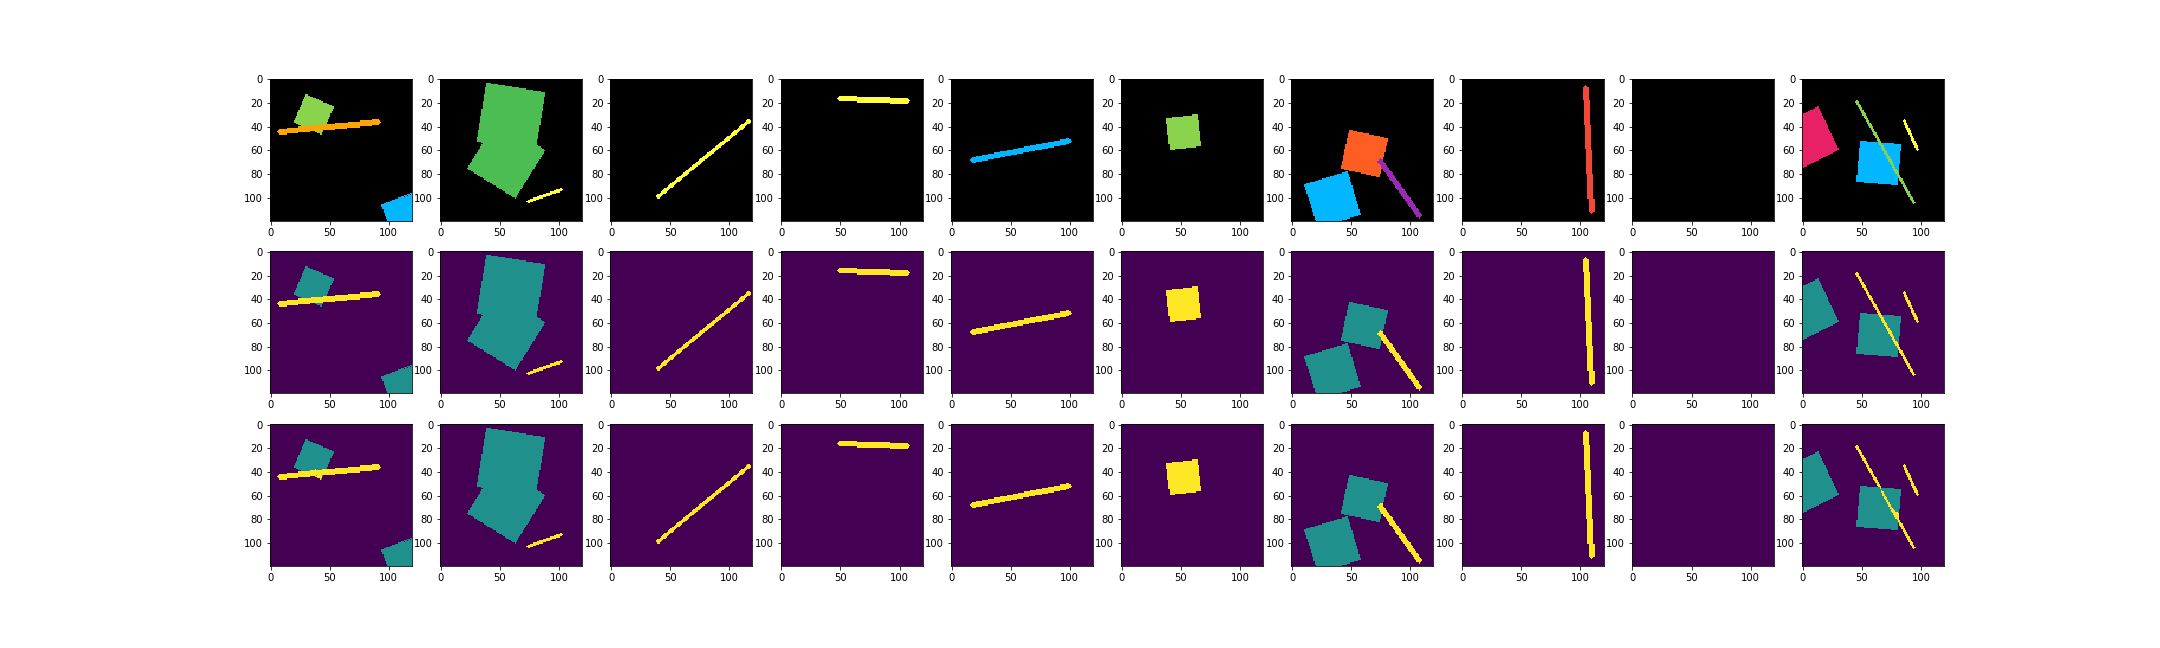

2018-04-15 18:07:47,270 Verification  loss= 0.0027,error rate= 0.1%, IOU = 0.9552, IOU Precision = 96.4722%, F1 IOU= 93.2875%
2018-04-15 18:07:47,678 Iter 0, Minibatch Loss= 0.0027, Minibatch error= 0.1%
2018-04-15 18:07:53,658 Iter 10, Minibatch Loss= 0.0024, Minibatch error= 0.1%
2018-04-15 18:07:59,612 Iter 20, Minibatch Loss= 0.0008, Minibatch error= 0.0%
2018-04-15 18:08:05,578 Iter 30, Minibatch Loss= 0.0017, Minibatch error= 0.1%
2018-04-15 18:08:11,503 Iter 40, Minibatch Loss= 0.0007, Minibatch error= 0.0%


Checkpoint 1600 saved !


2018-04-15 18:08:17,622 Iter 50, Minibatch Loss= 0.0033, Minibatch error= 0.1%
2018-04-15 18:08:23,597 Iter 60, Minibatch Loss= 0.0024, Minibatch error= 0.1%
2018-04-15 18:08:29,561 Iter 70, Minibatch Loss= 0.0020, Minibatch error= 0.0%
2018-04-15 18:08:35,535 Iter 80, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:08:41,526 Iter 90, Minibatch Loss= 0.0007, Minibatch error= 0.0%
2018-04-15 18:08:47,468 Iter 100, Minibatch Loss= 0.0015, Minibatch error= 0.0%
2018-04-15 18:08:53,466 Iter 110, Minibatch Loss= 0.0036, Minibatch error= 0.1%
2018-04-15 18:08:59,408 Iter 120, Minibatch Loss= 0.0015, Minibatch error= 0.1%
2018-04-15 18:09:05,339 Iter 130, Minibatch Loss= 0.0013, Minibatch error= 0.0%
2018-04-15 18:09:11,294 Iter 140, Minibatch Loss= 0.0030, Minibatch error= 0.1%
2018-04-15 18:09:17,239 Iter 150, Minibatch Loss= 0.0018, Minibatch error= 0.1%
2018-04-15 18:09:22,071  Training epoch_10, Minibatch Loss= 0.0019


<IPython.core.display.Javascript object>


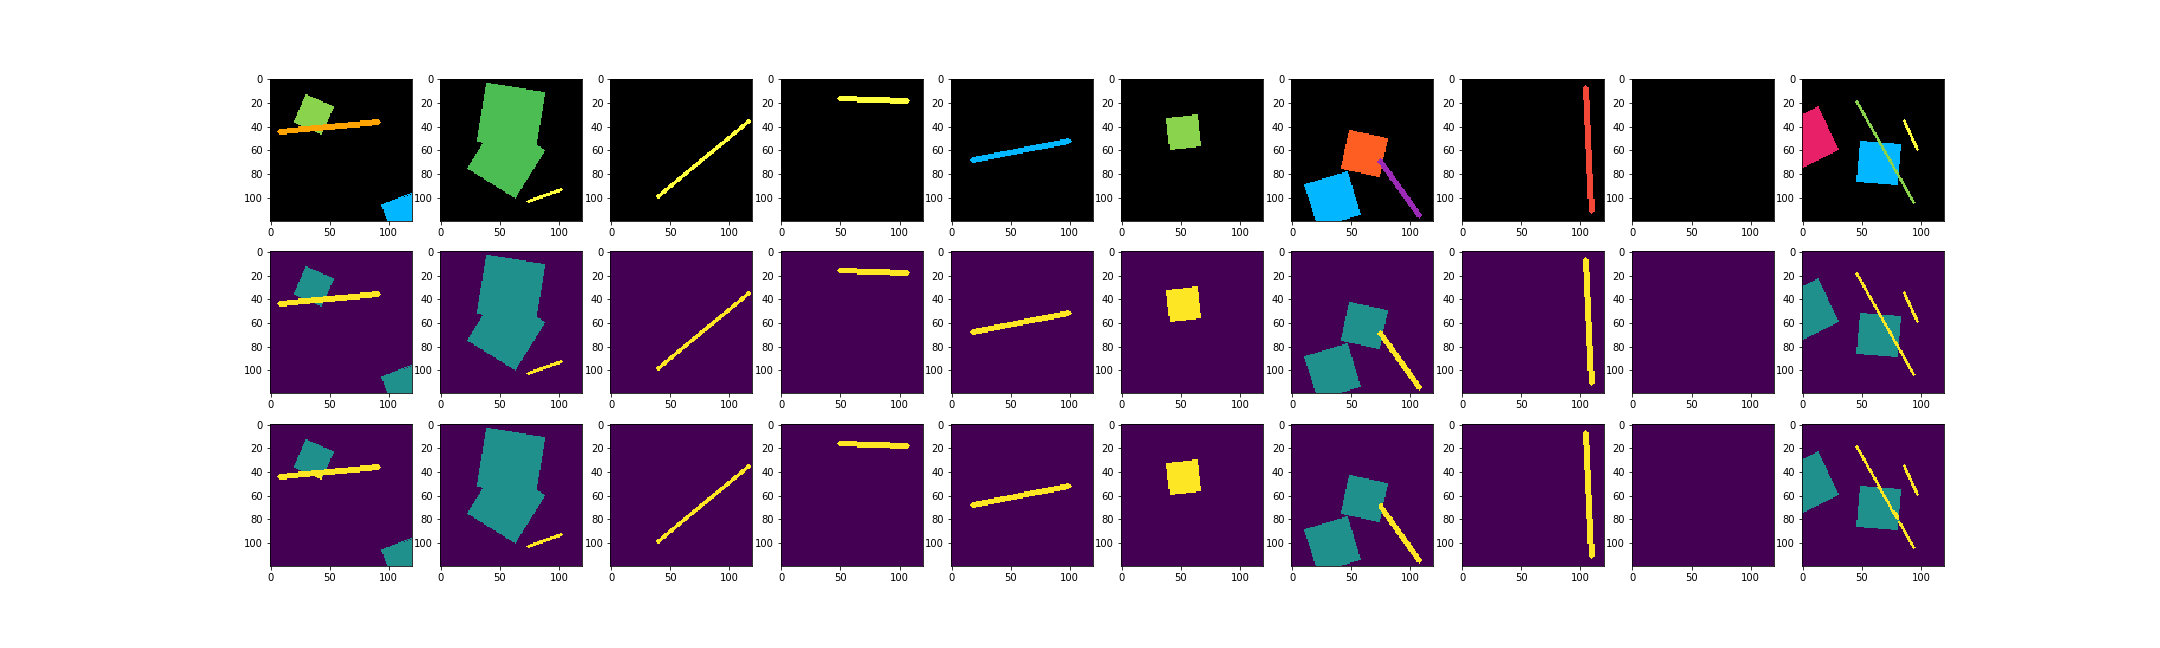

2018-04-15 18:09:32,631 Verification  loss= 0.0023,error rate= 0.1%, IOU = 0.9553, IOU Precision = 97.0278%, F1 IOU= 94.0833%
2018-04-15 18:09:33,057 Iter 0, Minibatch Loss= 0.0020, Minibatch error= 0.1%
2018-04-15 18:09:39,051 Iter 10, Minibatch Loss= 0.0026, Minibatch error= 0.1%
2018-04-15 18:09:45,005 Iter 20, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:09:51,005 Iter 30, Minibatch Loss= 0.0019, Minibatch error= 0.1%
2018-04-15 18:09:57,000 Iter 40, Minibatch Loss= 0.0007, Minibatch error= 0.0%
2018-04-15 18:10:02,960 Iter 50, Minibatch Loss= 0.0035, Minibatch error= 0.1%
2018-04-15 18:10:08,908 Iter 60, Minibatch Loss= 0.0027, Minibatch error= 0.1%
2018-04-15 18:10:14,850 Iter 70, Minibatch Loss= 0.0023, Minibatch error= 0.1%
2018-04-15 18:10:20,811 Iter 80, Minibatch Loss= 0.0004, Minibatch error= 0.0%
2018-04-15 18:10:26,780 Iter 90, Minibatch Loss= 0.0009, Minibatch error= 0.0%


Checkpoint 1800 saved !


2018-04-15 18:10:32,972 Iter 100, Minibatch Loss= 0.0020, Minibatch error= 0.1%
2018-04-15 18:10:38,977 Iter 110, Minibatch Loss= 0.0036, Minibatch error= 0.1%
2018-04-15 18:10:44,951 Iter 120, Minibatch Loss= 0.0021, Minibatch error= 0.1%
2018-04-15 18:10:50,867 Iter 130, Minibatch Loss= 0.0013, Minibatch error= 0.0%
2018-04-15 18:10:56,800 Iter 140, Minibatch Loss= 0.0031, Minibatch error= 0.1%
2018-04-15 18:11:02,739 Iter 150, Minibatch Loss= 0.0015, Minibatch error= 0.1%
2018-04-15 18:11:07,721  Training epoch_11, Minibatch Loss= 0.0017


<IPython.core.display.Javascript object>


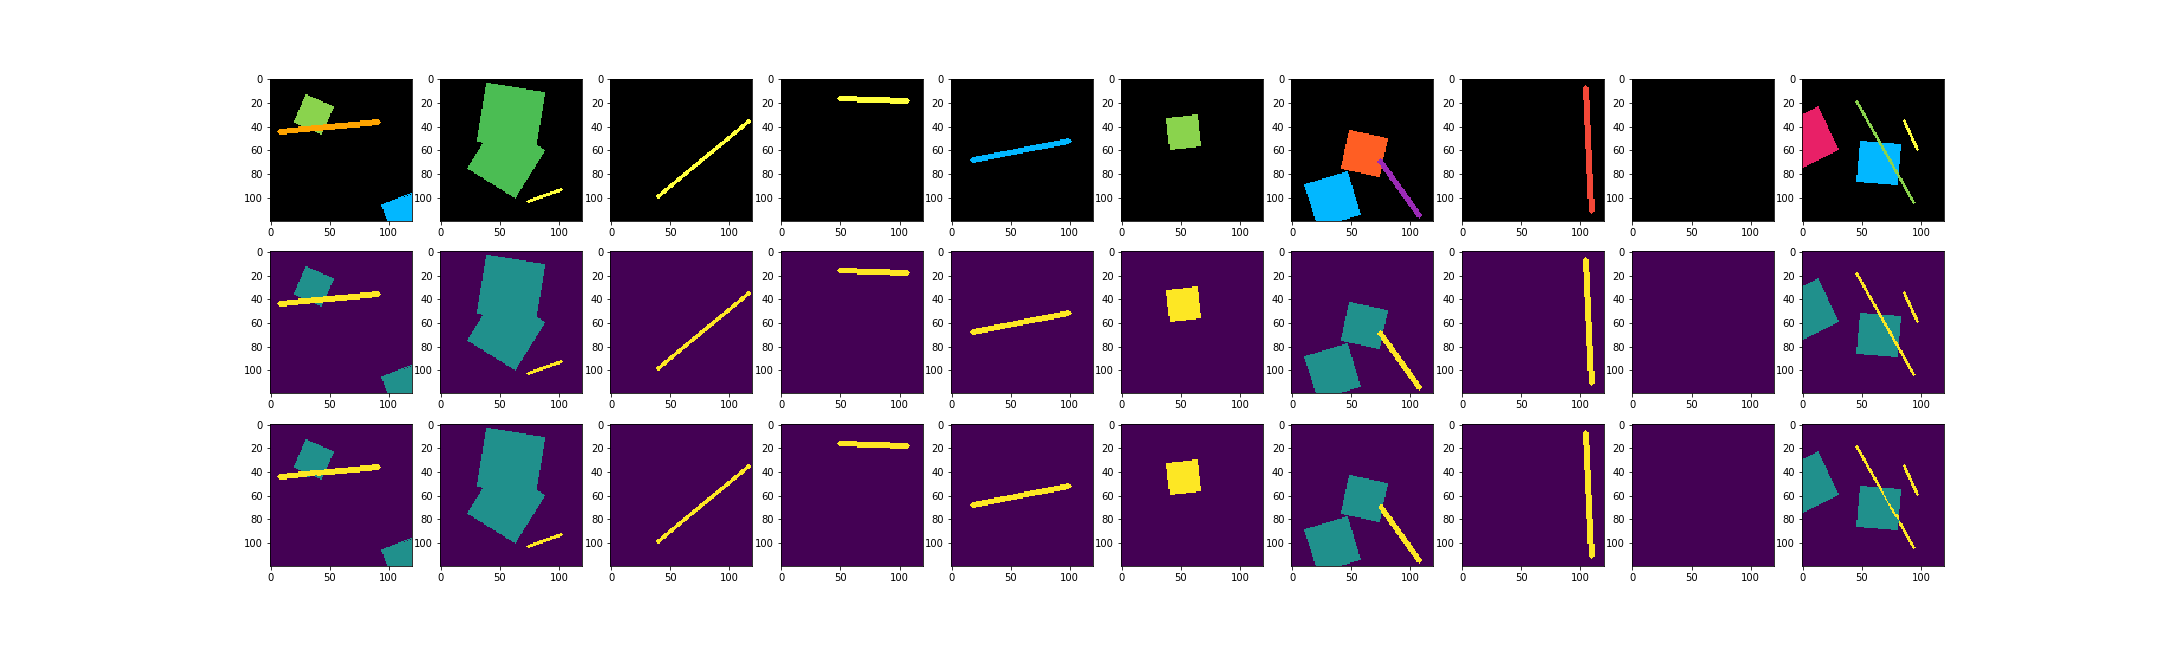

2018-04-15 18:11:19,057 Verification  loss= 0.0026,error rate= 0.1%, IOU = 0.9672, IOU Precision = 97.4444%, F1 IOU= 94.5366%
2018-04-15 18:11:19,473 Iter 0, Minibatch Loss= 0.0021, Minibatch error= 0.1%
2018-04-15 18:11:25,481 Iter 10, Minibatch Loss= 0.0024, Minibatch error= 0.1%
2018-04-15 18:11:31,445 Iter 20, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:11:37,391 Iter 30, Minibatch Loss= 0.0018, Minibatch error= 0.1%
2018-04-15 18:11:43,362 Iter 40, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:11:49,300 Iter 50, Minibatch Loss= 0.0038, Minibatch error= 0.1%
2018-04-15 18:11:55,241 Iter 60, Minibatch Loss= 0.0025, Minibatch error= 0.1%
2018-04-15 18:12:01,197 Iter 70, Minibatch Loss= 0.0021, Minibatch error= 0.0%
2018-04-15 18:12:07,148 Iter 80, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:12:13,099 Iter 90, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:12:19,113 Iter 100, Minibatch Loss= 0.0013, Minibatch error= 0.0%
2018-

Checkpoint 2000 saved !


2018-04-15 18:12:43,114 Iter 140, Minibatch Loss= 0.0026, Minibatch error= 0.1%
2018-04-15 18:12:49,118 Iter 150, Minibatch Loss= 0.0018, Minibatch error= 0.1%
2018-04-15 18:12:53,930  Training epoch_12, Minibatch Loss= 0.0017


<IPython.core.display.Javascript object>


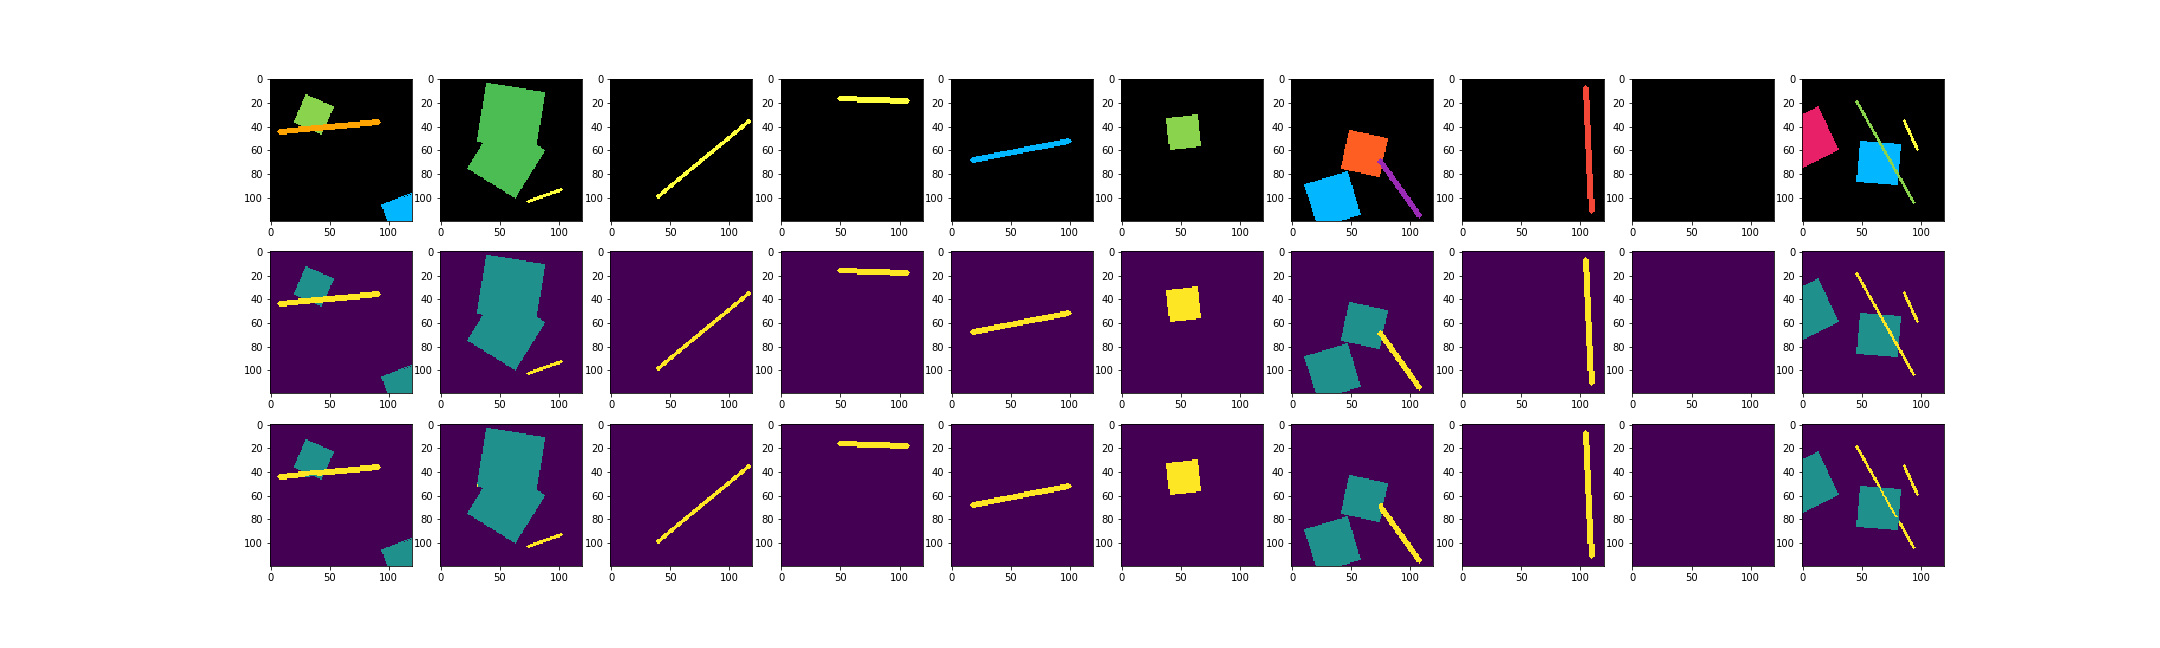

2018-04-15 18:13:05,136 Verification  loss= 0.0024,error rate= 0.1%, IOU = 0.9583, IOU Precision = 97.4444%, F1 IOU= 93.5694%
2018-04-15 18:13:05,574 Iter 0, Minibatch Loss= 0.0020, Minibatch error= 0.1%
2018-04-15 18:13:11,569 Iter 10, Minibatch Loss= 0.0020, Minibatch error= 0.1%
2018-04-15 18:13:17,546 Iter 20, Minibatch Loss= 0.0007, Minibatch error= 0.0%
2018-04-15 18:13:23,493 Iter 30, Minibatch Loss= 0.0014, Minibatch error= 0.1%
2018-04-15 18:13:29,477 Iter 40, Minibatch Loss= 0.0007, Minibatch error= 0.0%
2018-04-15 18:13:35,430 Iter 50, Minibatch Loss= 0.0027, Minibatch error= 0.1%
2018-04-15 18:13:41,369 Iter 60, Minibatch Loss= 0.0031, Minibatch error= 0.1%
2018-04-15 18:13:47,326 Iter 70, Minibatch Loss= 0.0019, Minibatch error= 0.0%
2018-04-15 18:13:53,322 Iter 80, Minibatch Loss= 0.0009, Minibatch error= 0.0%
2018-04-15 18:13:59,218 Iter 90, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:14:05,217 Iter 100, Minibatch Loss= 0.0010, Minibatch error= 0.0%
2018-

<IPython.core.display.Javascript object>


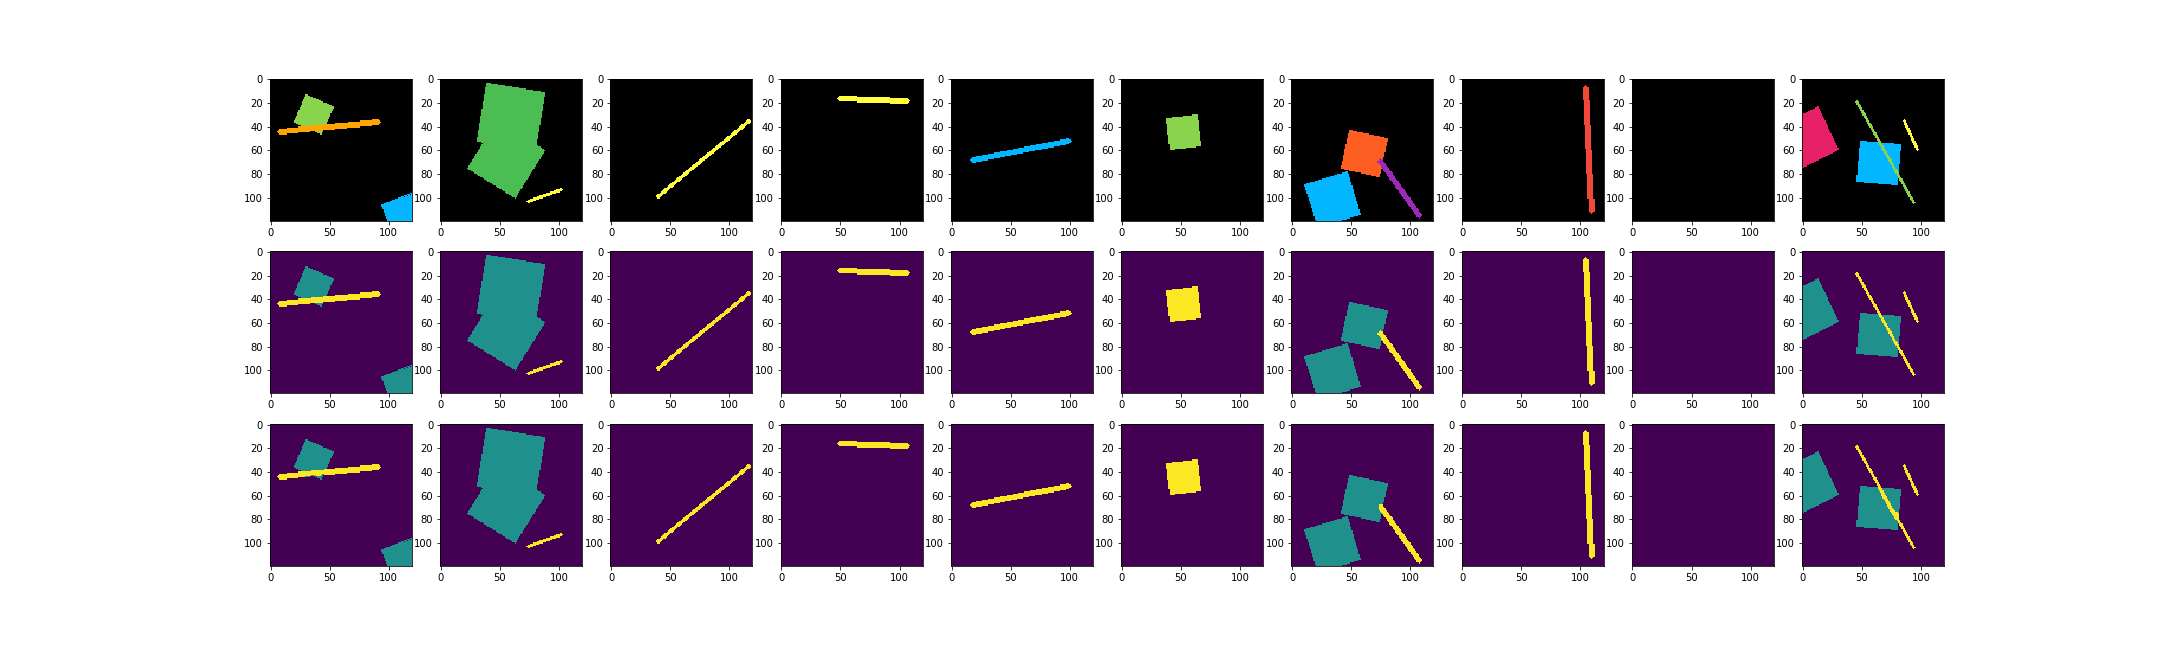

2018-04-15 18:14:49,869 Verification  loss= 0.0021,error rate= 0.1%, IOU = 0.9587, IOU Precision = 96.8889%, F1 IOU= 95.6400%
2018-04-15 18:14:50,292 Iter 0, Minibatch Loss= 0.0018, Minibatch error= 0.1%
2018-04-15 18:14:56,439 Iter 10, Minibatch Loss= 0.0027, Minibatch error= 0.1%
2018-04-15 18:15:02,393 Iter 20, Minibatch Loss= 0.0006, Minibatch error= 0.0%


Checkpoint 2200 saved !


2018-04-15 18:15:08,546 Iter 30, Minibatch Loss= 0.0012, Minibatch error= 0.0%
2018-04-15 18:15:14,503 Iter 40, Minibatch Loss= 0.0008, Minibatch error= 0.0%
2018-04-15 18:15:20,452 Iter 50, Minibatch Loss= 0.0028, Minibatch error= 0.1%
2018-04-15 18:15:26,431 Iter 60, Minibatch Loss= 0.0024, Minibatch error= 0.1%
2018-04-15 18:15:32,364 Iter 70, Minibatch Loss= 0.0022, Minibatch error= 0.0%
2018-04-15 18:15:38,326 Iter 80, Minibatch Loss= 0.0005, Minibatch error= 0.0%
2018-04-15 18:15:44,322 Iter 90, Minibatch Loss= 0.0005, Minibatch error= 0.0%
2018-04-15 18:15:50,256 Iter 100, Minibatch Loss= 0.0014, Minibatch error= 0.0%
2018-04-15 18:15:56,207 Iter 110, Minibatch Loss= 0.0039, Minibatch error= 0.1%
2018-04-15 18:16:02,158 Iter 120, Minibatch Loss= 0.0012, Minibatch error= 0.0%
2018-04-15 18:16:08,138 Iter 130, Minibatch Loss= 0.0013, Minibatch error= 0.0%
2018-04-15 18:16:14,142 Iter 140, Minibatch Loss= 0.0027, Minibatch error= 0.1%
2018-04-15 18:16:20,080 Iter 150, Minibatch Los

<IPython.core.display.Javascript object>


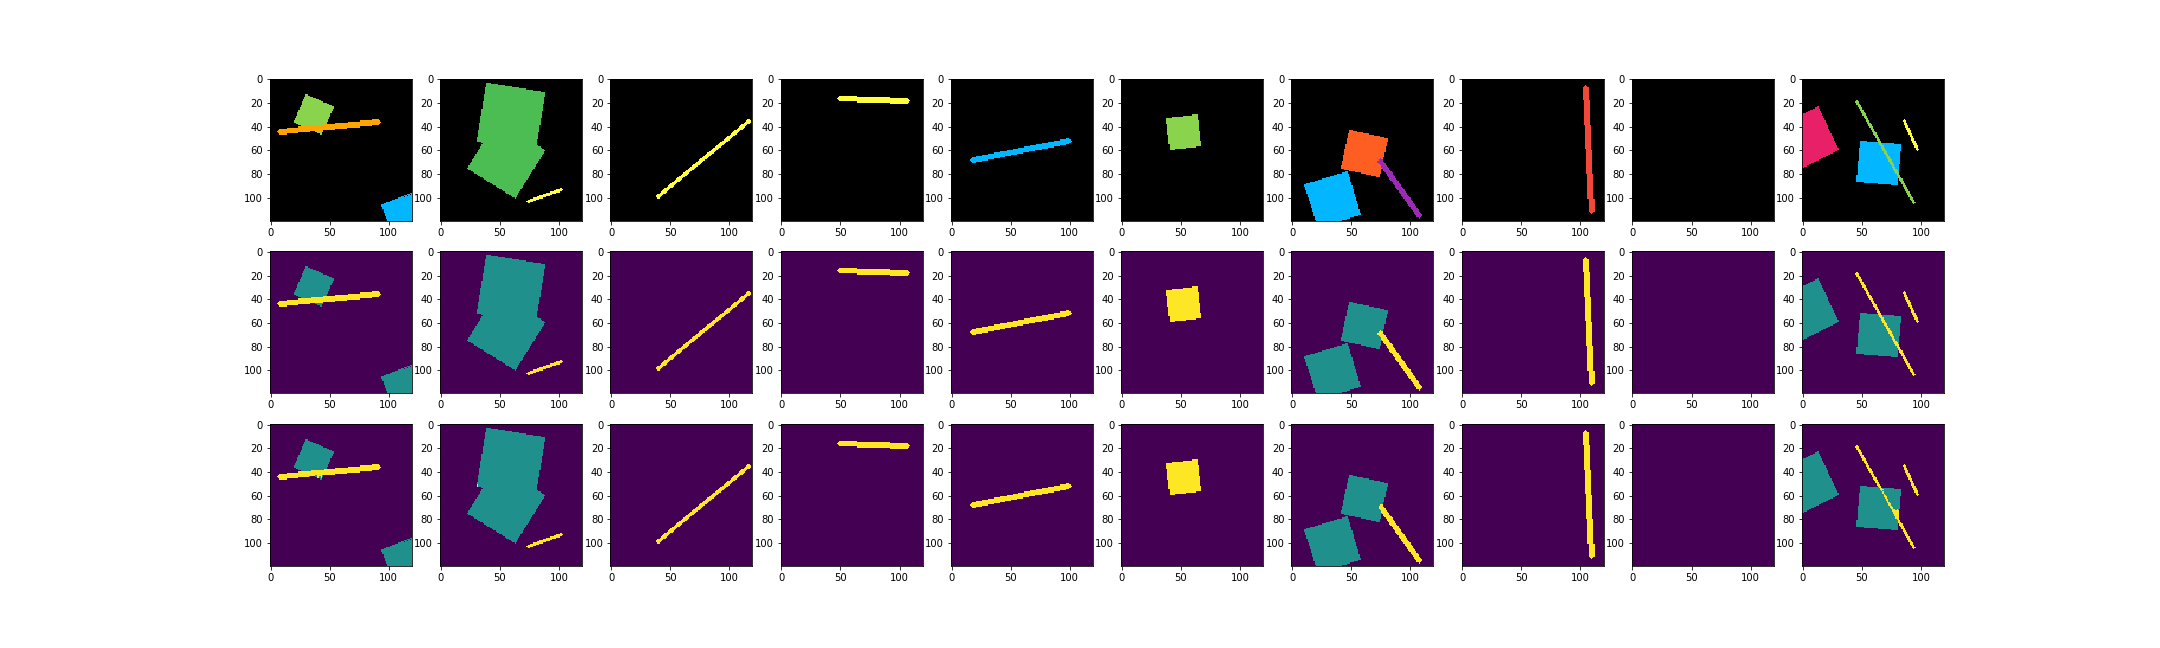

2018-04-15 18:16:35,807 Verification  loss= 0.0026,error rate= 0.1%, IOU = 0.9454, IOU Precision = 95.2500%, F1 IOU= 93.1933%
2018-04-15 18:16:36,223 Iter 0, Minibatch Loss= 0.0018, Minibatch error= 0.1%
2018-04-15 18:16:42,191 Iter 10, Minibatch Loss= 0.0024, Minibatch error= 0.1%
2018-04-15 18:16:48,158 Iter 20, Minibatch Loss= 0.0005, Minibatch error= 0.0%
2018-04-15 18:16:54,133 Iter 30, Minibatch Loss= 0.0013, Minibatch error= 0.1%
2018-04-15 18:17:00,085 Iter 40, Minibatch Loss= 0.0007, Minibatch error= 0.0%
2018-04-15 18:17:06,018 Iter 50, Minibatch Loss= 0.0034, Minibatch error= 0.1%
2018-04-15 18:17:11,978 Iter 60, Minibatch Loss= 0.0021, Minibatch error= 0.1%
2018-04-15 18:17:17,979 Iter 70, Minibatch Loss= 0.0020, Minibatch error= 0.0%


Checkpoint 2400 saved !


2018-04-15 18:17:24,061 Iter 80, Minibatch Loss= 0.0005, Minibatch error= 0.0%
2018-04-15 18:17:30,027 Iter 90, Minibatch Loss= 0.0005, Minibatch error= 0.0%
2018-04-15 18:17:35,997 Iter 100, Minibatch Loss= 0.0011, Minibatch error= 0.0%
2018-04-15 18:17:41,981 Iter 110, Minibatch Loss= 0.0038, Minibatch error= 0.1%
2018-04-15 18:17:47,930 Iter 120, Minibatch Loss= 0.0015, Minibatch error= 0.1%
2018-04-15 18:17:53,930 Iter 130, Minibatch Loss= 0.0012, Minibatch error= 0.0%
2018-04-15 18:17:59,895 Iter 140, Minibatch Loss= 0.0021, Minibatch error= 0.1%
2018-04-15 18:18:05,850 Iter 150, Minibatch Loss= 0.0021, Minibatch error= 0.1%
2018-04-15 18:18:10,806  Training epoch_15, Minibatch Loss= 0.0016


<IPython.core.display.Javascript object>


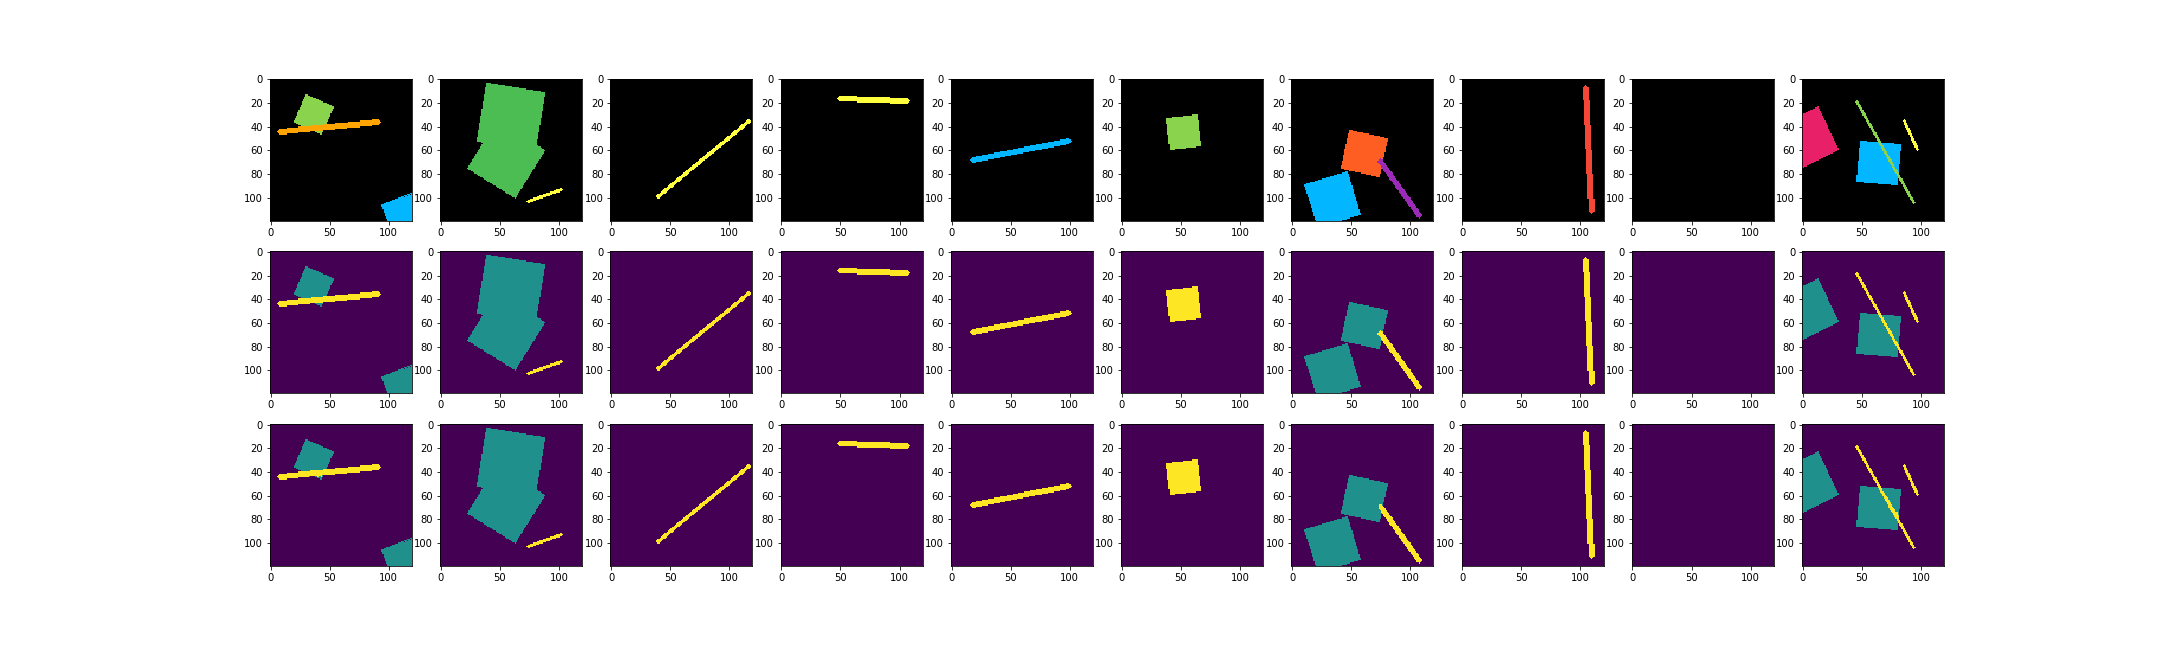

2018-04-15 18:18:22,034 Verification  loss= 0.0017,error rate= 0.1%, IOU = 0.9592, IOU Precision = 96.6667%, F1 IOU= 94.7443%
2018-04-15 18:18:22,480 Iter 0, Minibatch Loss= 0.0015, Minibatch error= 0.1%
2018-04-15 18:18:28,475 Iter 10, Minibatch Loss= 0.0022, Minibatch error= 0.1%
2018-04-15 18:18:34,464 Iter 20, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:18:40,418 Iter 30, Minibatch Loss= 0.0012, Minibatch error= 0.0%
2018-04-15 18:18:46,376 Iter 40, Minibatch Loss= 0.0007, Minibatch error= 0.0%
2018-04-15 18:18:52,341 Iter 50, Minibatch Loss= 0.0023, Minibatch error= 0.1%
2018-04-15 18:18:58,272 Iter 60, Minibatch Loss= 0.0025, Minibatch error= 0.1%
2018-04-15 18:19:04,262 Iter 70, Minibatch Loss= 0.0018, Minibatch error= 0.1%
2018-04-15 18:19:10,237 Iter 80, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:19:16,175 Iter 90, Minibatch Loss= 0.0006, Minibatch error= 0.0%
2018-04-15 18:19:22,173 Iter 100, Minibatch Loss= 0.0013, Minibatch error= 0.0%
2018-

Checkpoint 2600 saved !


2018-04-15 18:19:34,258 Iter 120, Minibatch Loss= 0.0010, Minibatch error= 0.0%
2018-04-15 18:19:40,238 Iter 130, Minibatch Loss= 0.0014, Minibatch error= 0.0%
2018-04-15 18:19:46,220 Iter 140, Minibatch Loss= 0.0020, Minibatch error= 0.1%
2018-04-15 18:19:52,183 Iter 150, Minibatch Loss= 0.0013, Minibatch error= 0.0%
2018-04-15 18:19:57,034  Training epoch_16, Minibatch Loss= 0.0015


<IPython.core.display.Javascript object>


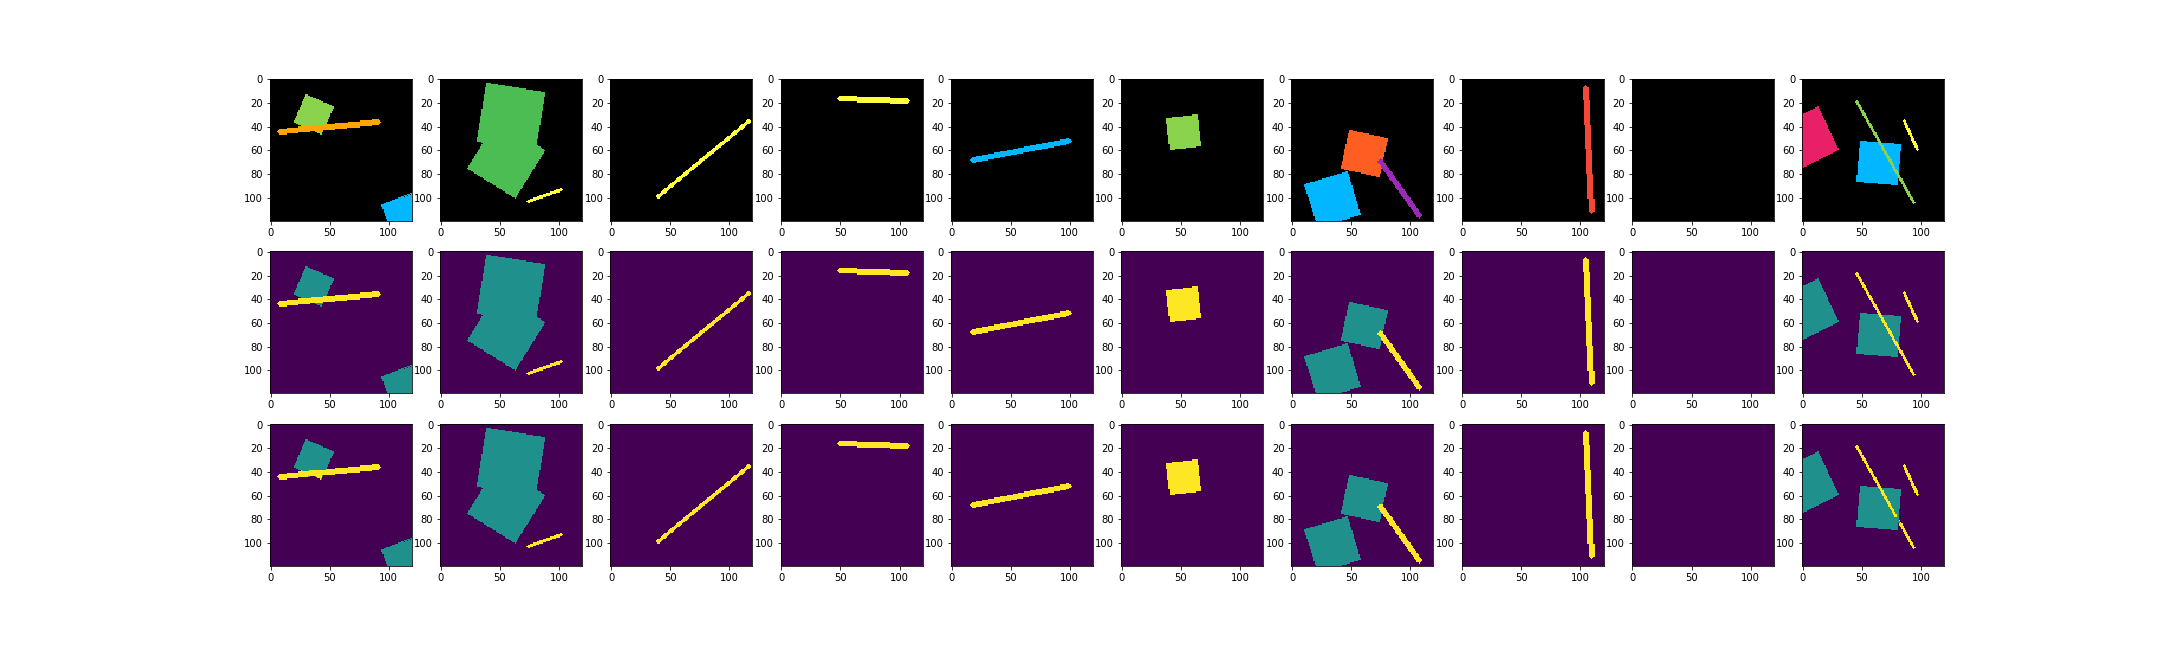

2018-04-15 18:20:08,617 Verification  loss= 0.0017,error rate= 0.1%, IOU = 0.9670, IOU Precision = 97.6944%, F1 IOU= 96.1987%
2018-04-15 18:20:09,065 Iter 0, Minibatch Loss= 0.0015, Minibatch error= 0.1%
2018-04-15 18:20:15,070 Iter 10, Minibatch Loss= 0.0016, Minibatch error= 0.1%
2018-04-15 18:20:21,037 Iter 20, Minibatch Loss= 0.0004, Minibatch error= 0.0%
2018-04-15 18:20:27,008 Iter 30, Minibatch Loss= 0.0012, Minibatch error= 0.0%
2018-04-15 18:20:32,945 Iter 40, Minibatch Loss= 0.0005, Minibatch error= 0.0%
2018-04-15 18:20:38,968 Iter 50, Minibatch Loss= 0.0032, Minibatch error= 0.1%
2018-04-15 18:20:44,968 Iter 60, Minibatch Loss= 0.0021, Minibatch error= 0.1%
2018-04-15 18:20:50,923 Iter 70, Minibatch Loss= 0.0019, Minibatch error= 0.0%
2018-04-15 18:20:56,895 Iter 80, Minibatch Loss= 0.0005, Minibatch error= 0.0%
2018-04-15 18:21:02,781 Iter 90, Minibatch Loss= 0.0005, Minibatch error= 0.0%
2018-04-15 18:21:08,724 Iter 100, Minibatch Loss= 0.0015, Minibatch error= 0.0%
2018-

<IPython.core.display.Javascript object>


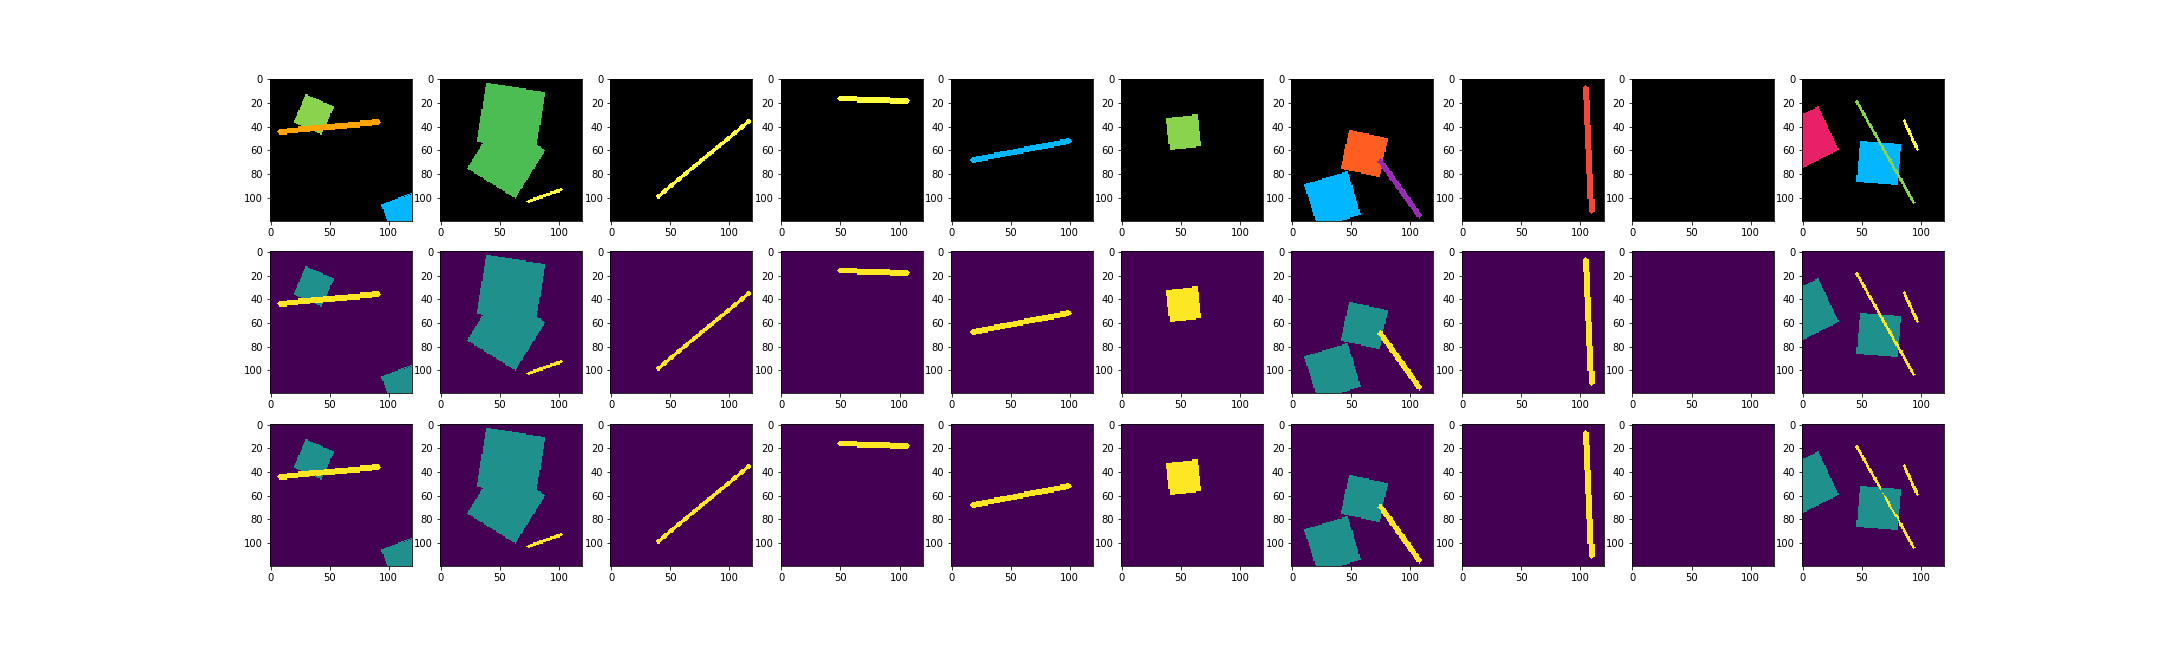

2018-04-15 18:21:54,620 Verification  loss= 0.0018,error rate= 0.1%, IOU = 0.9599, IOU Precision = 96.8889%, F1 IOU= 95.5719%


<IPython.core.display.Javascript object>


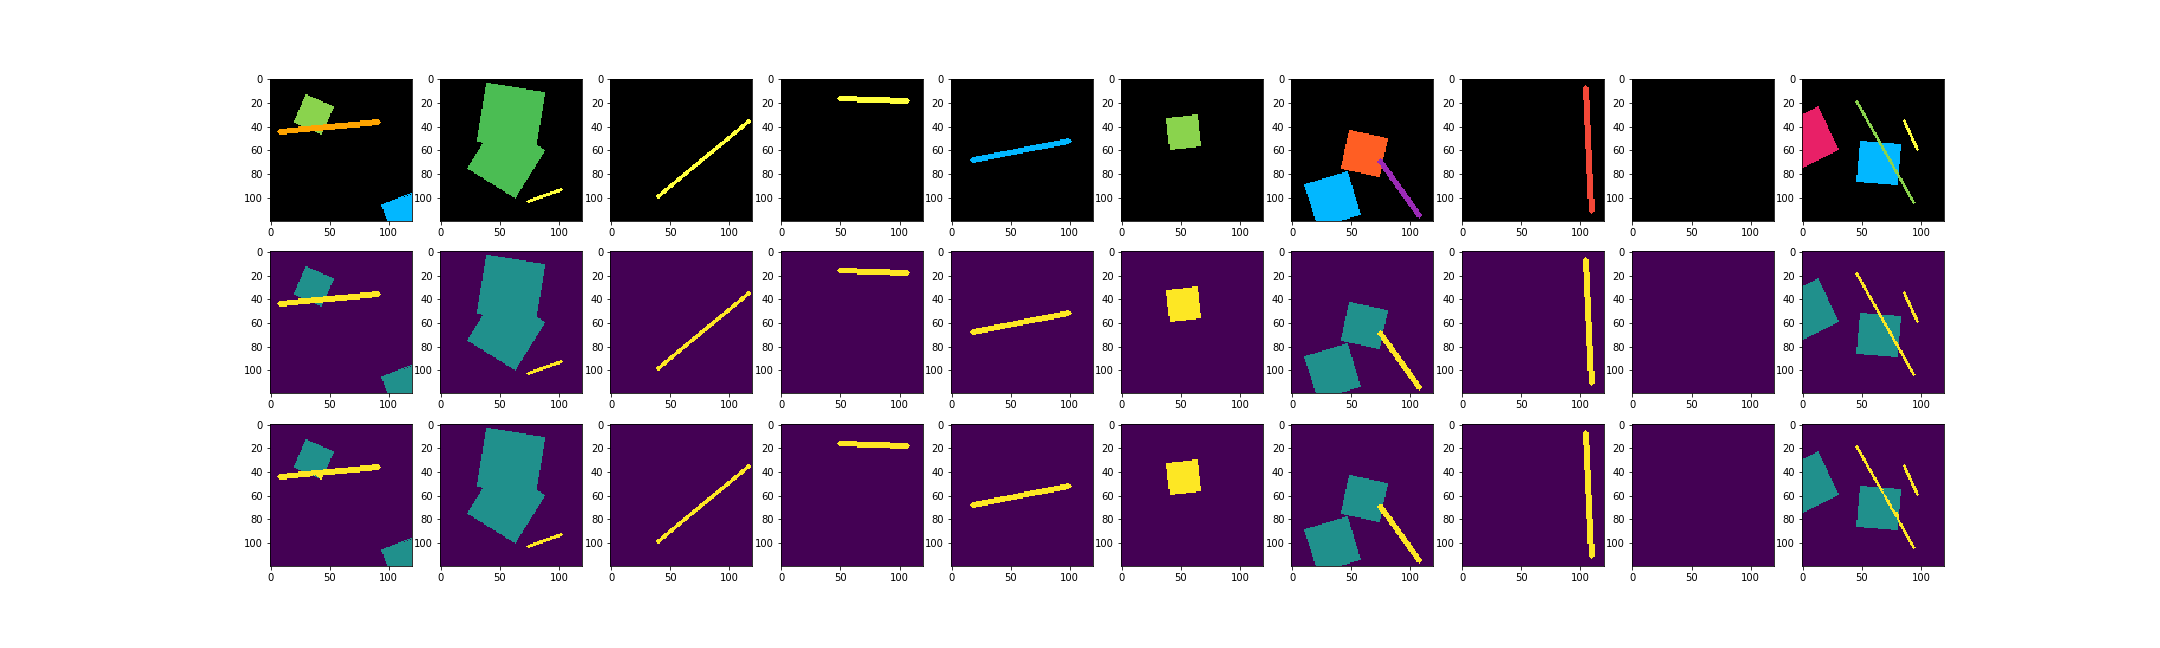

2018-04-15 18:22:07,271 Verification  loss= 0.0017,error rate= 0.1%, IOU = 0.9587, IOU Precision = 96.5833%, F1 IOU= 95.9003%


Last model saved is MODEL_SHAPE_PYTORCH_MELI/pytorch_shape_meli: 


<IPython.core.display.Javascript object>


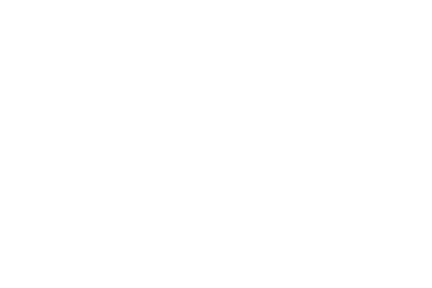

ref: (8, 120, 120, 3) | pred: (8, 120, 120)


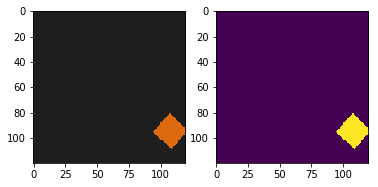

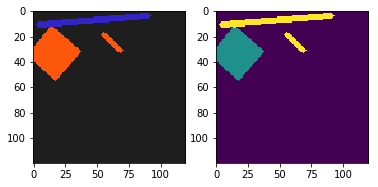

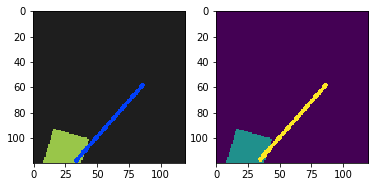

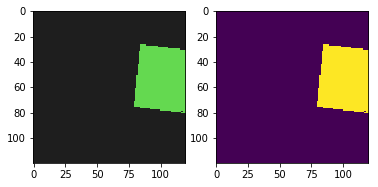

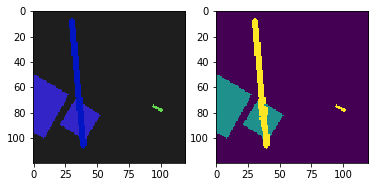

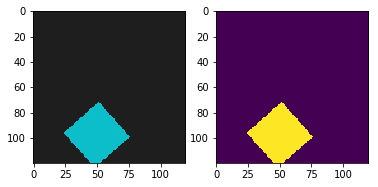

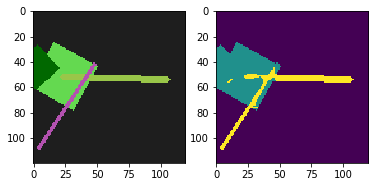

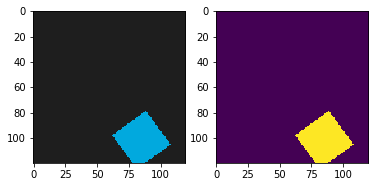

In [132]:
if __name__ == '__main__':

    
    model=UNet(INPUT_CHANNELS,NB_CLASSES,DEFAULT_LAYERS,DEFAULT_FEATURES_ROOT,DROPOUT)
    model.apply(weights_init)
    model.cuda()
    cudnn.benchmark = True
    trainer=Trainer(model,DEFAULT_BATCH_SIZE,DEFAULT_LR,NB_CLASSES)
    save_path,loss_train,loss_verif,iou_verif,iou_acc_verif,f1_iou_verif=trainer.train(  MODEL_PATH_SAVE, MODEL_PATH_RESTORE,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,REC_SAVE, TEST_SAVE)
    print('Last model saved is %s: '%save_path)
    #SAVE loss
    plt.subplot(1,4,1)
    plt.title('Plot Loss', fontsize=20)
    ite = np.arange(0,len(loss_train),1)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    plt.plot(ite,loss_train,'b',epo,loss_verif,'g')
    plt.ylabel('Loss')

    
     #SAVE IOU
    plt.subplot(1,4,2)
    plt.title('Plot IOU', fontsize=20)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    plt.plot(epo,iou_verif,'g')
    plt.ylabel('IOU in %')

    
    #SAVE IOU  acc
    plt.subplot(1,4,3)
    plt.title('Plot IOU Accuracy', fontsize=20)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    plt.plot(epo,iou_acc_verif,'g')
    plt.ylabel('IOU Accuracy in %')


    
     #SAVE f1 IOU
    plt.subplot(1,4,4)
    plt.title('Plot f1 IOU', fontsize=20)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    plt.plot(epo,f1_iou_verif,'g')
    plt.ylabel('f1 IOU in %')
    plt.show()
    
    %matplotlib inline
    
    test_batch_size=8
    val_generator=SimpleSegmentationDataset(SIZE_PATCH, 3, alpha =1.0,virtual_size=30)
    val_loader = DataLoader(val_generator, batch_size=test_batch_size,shuffle=True, num_workers=1)
    sample = next(iter(val_loader))
    
    x=sample["input"]
    x=x.permute(0,3,1,2)
    y=sample["groundtruth"]
    y=y.permute(0,3,1,2)
    x = Variable(x.float())
    y = Variable(y.float())

    x = x.cuda()
    y = y.cuda()
# Forward + Backward + Optimize
#     optimizer.zero_grad()
    y_ = model.forward(x)
    ref = x.cpu().data.numpy().transpose([0,2,3,1])
    target = y.cpu().data.numpy().transpose([0,2,3,1])
    pred = np.argmax(y_.cpu().data.numpy().transpose([0,2,3,1]),-1)
    print("ref:", ref.shape, "| pred:", pred.shape)
    for k in range(min(test_batch_size,10)):
        plt.subplot(1,2,1)
        plt.imshow(ref[k])
        plt.subplot(1,2,2)
        plt.imshow(pred[k])
        plt.show()


